# readme
descrip: plot geostrohphic mass flux (Vg*PD) and ageostrohphic mass flux (Vag*PD) at surface for reviewer #2 <br>

update history: <br>
v1.0 DL 2022Jan12 <br>
 
extra notes: <br>
for time series files such as UVEL, VVEL, PD <br>
=== HR === <br>
CESM-TNST HR Ens#1 has missing time: 2033-07, 2038-09, 2052-11<br>
CESM-CTRL HR does not have missing UVEL and VVEL<br>

=== LR ===<br>
CESM-TNST LR miss 2014-Jan (2014-02-01 monthly file) from time series file<br>
CESM-CTRL LR miss 0374-09, 0398-12, 0417-02, 0445-06, 0401-11 from time series file <br>

# import modules

In [1]:
# general python packages
import numpy as np
# from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
%matplotlib inline
import proplot as plot
import cartopy
# import cartopy.crs as ccrs
cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
# from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid
import glob

# python GCM(POP) packages
import xgcm
import pop_tools
# import xoak
# import xesmf as xe
import seawater 

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
from itertools import product
# from cftime import DatetimeNoLeap

# incorporate dask 

In [2]:
client = Client("tcp://10.73.3.176:44618")
client

<Client: 'tcp://10.73.3.176:44618' processes=16 threads=16, memory=316.64 GiB>

# define parameters

In [3]:
# === r: region (US east coast excluding Gulf of Mexico) ===
# reference: Plot2FindGulfMexicoYucatanChannelFLstraitnlatnlonIndex_2021Jul20.ipynb


# nlon1_r_g16, nlon2_r_g16 = 260, 321
# nlat1_r_g16, nlat2_r_g16 = 230, 350

lon1_r, lon2_r = -85, -50
lat1_r, lat2_r = 25, 55
# ===========================================================

z = 15*100 # 15 m 
g = 9.8 # gravity acceleration
# rho0 = 1035 # reference density, see Fox-Kemper and Ferrari (2008) Table 1
omega = 7.29e-5 # Earths Angular Velocity, [rad/s], from POP model output
# deg2rad, rad2deg = np.pi/180.0,  180.0/np.pi # Angle conversions 

# time2 = np.arange(2001,2100+1,1)

chunks_HR = {'nlat':400,'nlon':300,'z_t':1}
chunks_LR = {'nlat':384,'nlon':320,'z_t':1}

outdir = '/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic1 = outdir + 'VELintegrationSSH_USEastCoastCESM4reviewer2_2022Feb06.png'

In [4]:
# function to compute gradient 
# copied by DL on 2022Jan07 from https://github.com/NCAR/pop-tools/blob/master/docs/source/examples/pop_div_curl_xr_xgcm_metrics_compare.ipynb

def x_gradh(F, grid):
    """
    gradient of scalar xgcm_metrics
    for pop
    """
    F_yi = grid.interp(F, axis="Y", boundary="extend")  # 0.5*(F[i,j+1]+F[i,j])
    F_xi = grid.interp(F, axis="X", boundary="extend")  # 0.5*(F[i+1,j]+F[i,j])
    dFdx = grid.derivative(F_yi, axis="X", boundary="extend")
    dFdy = grid.derivative(F_xi, axis="Y", boundary="extend")
    return dFdx, dFdy

# read files

In [5]:
# read ssh TH

# --- infiles below return error when converting them to xgcm object (do not use) --- 
# infile_ssh_TH = ('/ihesp/archive/Sunway_Runs/HR_HF_TNST/'
#                  'B.E.13.BTRANS.ne120_t12.sehires38.003.sunway.pop.h.SSH.185001.210012.nc')
# infile0_ssh_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/SSH/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.nday1.SSH.200601-201512.nc')
# infile0_ssh_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/SSH/'
#                   'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.nday1.SSH.200001-200611.nc')

# ds_ssh_TH = xr.open_dataset(infile_ssh_TH, chunks={'nlat':400,'nlon':300})
# ds0_ssh_TH = xr.open_dataset(infile0_ssh_TH, chunks={'nlat':400,'nlon':300})
# ds_ssh_TH
# -----------------------------------------------------------------------------------

infile1_ssh_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/SSH/'
                  'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.nday1.SSH.200001-200611.nc')

indir2_ssh_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/SSH/')
infiles2_ssh_TH = sorted(glob.glob(indir2_ssh_TH + 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop*'))
print('first file: ', infiles2_ssh_TH[0])
print('last file: ', infiles2_ssh_TH[-1])

ds1_ssh_TH_raw = xr.open_dataset(infile1_ssh_TH, chunks={'nlat':400,'nlon':300})
ds1_ssh_TH = ds1_ssh_TH_raw.sel(time=slice('2001-02','2006-01'))
print('ds1_ssh_TH first time: ', ds1_ssh_TH.time[0].values)
print('ds1_ssh_TH end time: ', ds1_ssh_TH.time[-1].values)

ds2_ssh_TH = xr.open_mfdataset(infiles2_ssh_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks={'nlat':400,'nlon':300}, parallel=True)
print('ds2_ssh_TH first time: ', ds2_ssh_TH.time[0].values)
print('ds2_ssh_TH end time: ', ds2_ssh_TH.time[-1].values)
ds_ssh_TH = xr.concat([ds1_ssh_TH, ds2_ssh_TH], dim="time")
ds_ssh_TH

# # ssh daily data files for filling missing monthly values in ppt
# indir_ssh_daily_THe0 = '/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/daily/'
# infile_ssh_203307_THe0 = indir_ssh_daily_THe0 + 'cmpr_B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.nday1.2033-07-01.nc'
# infile_ssh_203809_THe0 = indir_ssh_daily_THe0 + 'cmpr_B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.nday1.2038-09-01.nc'
# infile_ssh_205211_THe0 = indir_ssh_daily_THe0 + 'cmpr_B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.nday1.2052-11-01.nc'

# ds_ssh_203307_THe0 = xr.open_dataset(infile_ssh_203307_THe0, chunks={'time':1})
# ds_ssh_203809_THe0 = xr.open_dataset(infile_ssh_203809_THe0, chunks={'time':1})
# ds_ssh_205211_THe0 = xr.open_dataset(infile_ssh_205211_THe0, chunks={'time':1})

# # ds_ssh_daily_TH = xr.open_mfdataset([infile_ssh_203307_THe0, infile_ssh_203809_THe0, infile_ssh_205211_THe0], compat="override", combine="by_coords", 
# #                                data_vars="minimal", coords="minimal", chunks={'nlat':400,'nlon':300}, parallel=True)
# # ds_ssh_daily_TH
# infile_ssh_daily_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/tseries3/ocn/to_archive/'
# 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.nday1.SSH.202001-210012.nc')
# ds_ssh_daily_TH = xr.open_dataset(infile_ssh_daily_TH, chunks={'time':1})
# ds_ssh_daily_TH

first file:  /ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/SSH/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.nday1.SSH.200601-201512.nc
last file:  /ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/SSH/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.nday1.SSH.209601-210202.nc
ds1_ssh_TH first time:  2001-02-01 00:00:00
ds1_ssh_TH end time:  2006-01-01 00:00:00
ds2_ssh_TH first time:  2006-02-01 00:00:00
ds2_ssh_TH end time:  2101-01-01 00:00:00


<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    TLAT                (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    TLONG               (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    ULAT                (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    ULONG               (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
  * time                (time) object 2001-02-01 00:00:00 ... 2101-01-01 00:0...
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/51)
    ANGLE               (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    ANGLET              (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    DXT                 (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    DXU                 (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    DYT                 (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    DYU                 (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    (time) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
    sflux_factor        (time) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    sound               (time) float64 1.5e+05 1.5e+05 ... 1.5e+05 1.5e+05
    stefan_boltzmann    (time) float64 5.67e-08 5.67e-08 ... 5.67e-08 5.67e-08
    time_bound          (time, d2) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    vonkar              (time) float64 0.4 0.4 0.4 0.4 0.4 ... 0.4 0.4 0.4 0.4
Attributes: (12/14)
    title:                      B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:                    Mon Aug 30 17:53:01 2021: ncap2 -A -s time=ud...
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    contents:                   Diagnostic and Prognostic Variables
    source:                     CCSM POP2, the CCSM Ocean Component
    revision:                   $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlev...
    ...                         ...
    cell_methods:               cell_methods = time: mean ==> the variable va...
    nsteps_total:               2296931
    tavg_sum:                   2678400.0
    tavg_sum_qflux:             2678400.0
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...
    history_of_appended_files:  Mon Aug 30 15:43:41 2021: Appended file time_...

In [6]:
# read ssh CH
indir_ssh_CH = ('/ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/SSH/')
infiles_ssh_CH = sorted(glob.glob(indir_ssh_CH + 'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.nday1.SSH.04*'))
infile1_ssh_CH = indir_ssh_CH + 'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.nday1.SSH.050001-050912.nc'
infiles_ssh_CH.append(infile1_ssh_CH)
print('first file: ', infiles_ssh_CH[0])
print('last file: ', infiles_ssh_CH[-1])

ds_ssh_CH_raw = xr.open_mfdataset(infiles_ssh_CH, compat="override", combine="by_coords", 
                                  data_vars="minimal", coords="minimal", chunks={'nlat':400,'nlon':300}, parallel=True)
print('ds2_ssh_CH_raw first time: ', ds_ssh_CH_raw.time[0].values)
print('ds2_ssh_CH_raw end time: ', ds_ssh_CH_raw.time[-1].values)

ds_ssh_CH = ds_ssh_CH_raw.isel(time=slice(12,-9*12))
print('ds2_ssh_CH first time: ', ds_ssh_CH.time[0].values)
print('ds2_ssh_CH end time: ', ds_ssh_CH.time[-1].values)
print('ds2_ssh_CH # time: ', len(ds_ssh_CH.time))

ds_ssh_CH

first file:  /ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/SSH/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.nday1.SSH.040001-040912.nc
last file:  /ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/SSH/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.nday1.SSH.050001-050912.nc
ds2_ssh_CH_raw first time:  0400-02-01 00:00:00
ds2_ssh_CH_raw end time:  0510-01-01 00:00:00
ds2_ssh_CH first time:  0401-02-01 00:00:00
ds2_ssh_CH end time:  0501-01-01 00:00:00
ds2_ssh_CH # time:  1200


<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 0401-02-01 00:00:00 ... 0501-01-01 00:0...
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/51)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(108, 2), meta=np.ndarray>
    vonkar              float64 ...
Attributes: (12/14)
    title:                      B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02
    history:                    Wed Jul 28 20:33:35 2021: ncks -4 -L 1 tmp.nc...
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    contents:                   Diagnostic and Prognostic Variables
    source:                     CCSM POP2, the CCSM Ocean Component
    revision:                   $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlev...
    ...                         ...
    cell_methods:               cell_methods = time: mean ==> the variable va...
    nsteps_total:               68119571
    tavg_sum:                   2678400.0
    tavg_sum_qflux:             2678400.0
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...
    history_of_appended_files:  Wed Jul 28 20:33:32 2021: Appended file time_...

In [7]:
# read ssh TL
infile_ssh_TL = ('/ihesp/archive/Sunway_Runs/LR_HF_TNST/'
                 'B.E.13.BTRANS.ne30g16.sehires38.003.sunway.pop.h.SSH.185001.210012.nc')
ds_ssh_TL_raw = xr.open_dataset(infile_ssh_TL, chunks={'nlat':384,'nlon':320/5})
ds_ssh_TL = ds_ssh_TL_raw.sel(time=slice('2001-01','2100-12'))

print('ds_ssh_TL first time: ', ds_ssh_TL.time[0].values)
print('ds_ssh_TL end time: ', ds_ssh_TL.time[-1].values)
print('ds_ssh_TL # time: ', len(ds_ssh_TL.time))

ds_ssh_TL

ds_ssh_TL first time:  2001-01-17 00:00:00
ds_ssh_TL end time:  2100-12-17 00:00:00
ds_ssh_TL # time:  1200


<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1200)
Coordinates:
  * time        (time) object 2001-01-17 00:00:00 ... 2100-12-17 00:00:00
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 64), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 64), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(1200, 2), meta=np.ndarray>
    SSH         (time, nlat, nlon) float32 dask.array<chunksize=(1200, 384, 64), meta=np.ndarray>
Attributes: (12/13)
    title:           B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:         Thu May 14 01:43:04 2020: ncra -O -v SSH /home/export/on...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2020-04-11 at 22:12:21.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    25
    tavg_sum:        86400.0
    tavg_sum_qflux:  86400.0
    NCO:             netCDF Operators version 4.9.1 (Homepage = http://nco.sf...

In [8]:
infile_ssh_CL = ('/ihesp/archive/Sunway_Runs/LR_PI_CTRL/'
                 'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.SSH.000101.050012.nc')
ds_ssh_CL_raw = xr.open_dataset(infile_ssh_CL, chunks={'nlat':384,'nlon':320/5})
print('ds_ssh_CL_raw time[0]', ds_ssh_CL_raw.time[0].values)
print('ds_ssh_CL_raw time[-1]', ds_ssh_CL_raw.time[-1].values)
# 250-->1850, 500-->2100
# 1-->1621, # 1850-(250-1)=1601
# time_CL = xr.cftime_range(start="1601-01", end="2101-01", freq='M')
# 2101-01 is not included, the last time is 2100-12
# ds_CL = ds_CL_raw.sel(time=slice(400))
# ds_CL = ds_CL_raw.assign_coords(time=time_CL)
ds_ssh_CL = ds_ssh_CL_raw.sel(time=slice('0401','0500'))
print('ds_ssh_CL time[0]', ds_ssh_CL.time[0].values)
print('ds_ssh_CL time[-1]', ds_ssh_CL.time[-1].values)
print('ds_ssh_CL # time', len(ds_ssh_CL.time))
ds_ssh_CL

ds_ssh_CL_raw time[0] 0001-02-01 00:00:00
ds_ssh_CL_raw time[-1] 0500-12-17 00:00:00
ds_ssh_CL time[0] 0401-01-17 00:00:00
ds_ssh_CL time[-1] 0500-12-17 00:00:00
ds_ssh_CL # time 1200


<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1200)
Coordinates:
  * time        (time) object 0401-01-17 00:00:00 ... 0500-12-17 00:00:00
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 64), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 64), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(1200, 2), meta=np.ndarray>
    SSH         (time, nlat, nlon) float32 dask.array<chunksize=(1200, 384, 64), meta=np.ndarray>
Attributes:
    title:           B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2020-03-12 at 12:53:17.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    750
    tavg_sum:        2592000.0
    tavg_sum_qflux:  2592000.0

In [9]:
# read U, V vel TH 

# --- read one file ---
# infile_uvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UVEL/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.UVEL.200601-200612.nc')
# ds_uvel_TH = xr.open_dataset(infile_uvel_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_uvel_TH

# infile_vvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VVEL/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.VVEL.200601-200612.nc')
# ds_vvel_TH = xr.open_dataset(infile_vvel_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_vvel_TH
# ---------------------


# example file: 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_TH = np.arange(2001,2005+1) 
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_uvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UVEL/')
infiles1a_uvel_TH = [indir1a_uvel_TH + prefix1a_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_uvel_TH

indir1a_vvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VVEL/')
infiles1a_vvel_TH = [indir1a_vvel_TH + prefix1a_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_vvel_TH


yrs2_TH = np.arange(2006,2100+1)
prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_uvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UVEL/')
infiles2_uvel_TH = [indir1b_uvel_TH + prefix2_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_uvel_TH

indir1b_vvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VVEL/')
infiles2_vvel_TH = [indir1b_vvel_TH + prefix2_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_vvel_TH


ds_uvel_TH = xr.open_mfdataset(infiles1a_uvel_TH + infiles2_uvel_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

ds_vvel_TH = xr.open_mfdataset(infiles1a_vvel_TH + infiles2_vvel_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_vvel_TH first time: ', ds_vvel_TH.time[0].values)
print('ds_vvel_TH end time: ', ds_vvel_TH.time[-1].values)
print('ds_vvel_TH # time: ', len(ds_vvel_TH.time))
ds_vvel_TH

ds_vvel_TH first time:  2001-02-01 00:00:00
ds_vvel_TH end time:  2101-01-01 00:00:00
ds_vvel_TH # time:  1200


<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 2001-02-01 00:00:00 ... 2101-01-01 00:0...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/51)
    dz                  (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    salinity_factor     float64 ...
    sflux_factor        float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    VVEL                (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Thu Aug 26 14:23:01 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-03-16 at 08:33:13.4
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  34411091
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [10]:
# read CH U, V vel

# 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_CH = np.arange(401,500+1) 
prefix1a_CH = 'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.'

indir1a_uvel_CH = ('/ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/UVEL/')
infiles1a_uvel_CH = [indir1a_uvel_CH + prefix1a_CH + 'UVEL.' + str(iyr).zfill(4) +'01-' + str(iyr).zfill(4)+ '12.nc'
                     for iyr in yrs1a_CH]
infiles1a_uvel_CH

indir1a_vvel_CH = ('/ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/VVEL/')
infiles1a_vvel_CH = [indir1a_vvel_CH + prefix1a_CH + 'VVEL.' + str(iyr).zfill(4) +'01-' + str(iyr).zfill(4)+ '12.nc'
               for iyr in yrs1a_CH]
infiles1a_vvel_CH

ds_uvel_CH = xr.open_mfdataset(infiles1a_uvel_CH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)

ds_vvel_CH = xr.open_mfdataset(infiles1a_vvel_CH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)

print('ds_vvel_CH first time: ', ds_vvel_CH.time[0].values)
print('ds_vvel_CH end time: ', ds_vvel_CH.time[-1].values)
print('ds_vvel_CH # time: ', len(ds_vvel_CH.time))
ds_vvel_CH 

ds_vvel_CH first time:  0401-02-01 00:00:00
ds_vvel_CH end time:  0501-01-01 00:00:00
ds_vvel_CH # time:  1200


<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 0401-02-01 00:00:00 ... 0501-01-01 00:0...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/51)
    dz                  (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    salinity_factor     float64 ...
    sflux_factor        float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    VVEL                (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
Attributes:
    title:         B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02
    history:       Sat Jul 24 15:04:58 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-01-03 at 01:54:07.7
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  86568131
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [11]:
# read U, V TL
infile1_uvel_TL = ('/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
                   'B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.UVEL.185001-200512.nc')
infile1_vvel_TL = ('/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
                   'B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.VVEL.185001-200512.nc')

infile2_uvel_TL = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/tseries/ocn/to_archive/'
                   'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.UVEL.200601-210512.nc')
infile2_vvel_TL = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/tseries/ocn/to_archive/'
                   'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.VVEL.200601-210512.nc')

ds_uvel_TL_raw = xr.open_mfdataset([infile1_uvel_TL, infile2_uvel_TL], compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_LR, parallel=True)

ds_vvel_TL_raw = xr.open_mfdataset([infile1_vvel_TL, infile2_vvel_TL], compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_LR, parallel=True)

# === 2022Jan10 directly selecting time (codes below) returns errors due to different calendar types === 
# ds_uvel_TL = ds_uvel_TL_raw.sel(time=slice('2001-01','2101-01'))
# TypeError: cannot compare cftime.datetime(1978, 1, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True) and 
#     cftime.datetime(2001, 1, 1, 0, 0, 0, 0, calendar='gregorian', has_year_zero=False)
# ========================================================================================

# 2001-1850=151 yr, 2100-2001+1=100 yr
time_vvel_s_TL = ds_vvel_TL_raw.time.to_pandas().index.shift(-1,'D') # shift it one month back 
ds_uvel_TL = ds_uvel_TL_raw.assign_coords(time=time_vvel_s_TL).sel(time=slice('2001','2100'))
ds_vvel_TL = ds_vvel_TL_raw.assign_coords(time=time_vvel_s_TL).sel(time=slice('2001','2100'))

print('ds_vvel_TL first time: ', ds_vvel_TL.time[0].values)
print('ds_vvel_TL end time: ', ds_vvel_TL.time[-1].values)
print('ds_vvel_TL # time: ', len(ds_vvel_TL.time)) # miss 2014-Jan (2014-02-01 monthly file) from vvel data file

ds_uvel_TL

ds_vvel_TL first time:  2001-01-31 00:00:00
ds_vvel_TL end time:  2100-12-31 00:00:00
ds_vvel_TL # time:  1199


<xarray.Dataset>
Dimensions:               (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nchar: 256, nlat: 384, nlon: 320, time: 1199, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid          (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                 (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                  (time) object 2001-01-31 00:00:00 ... 2100-12-31 00...
Dimensions without coordinates: d2, moc_comp, nchar, nlat, nlon, transport_comp, transport_reg
Data variables: (12/54)
    moc_components        (moc_comp, nchar) |S1 dask.array<chunksize=(3, 256), meta=np.ndarray>
    transport_components  (transport_comp, nchar) |S1 dask.array<chunksize=(5, 256), meta=np.ndarray>
    transport_regions     (transport_reg, nchar) |S1 dask.array<chunksize=(2, 256), meta=np.ndarray>
    dz                    (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                   (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                    ...
    salinity_factor       float64 ...
    sflux_factor          float64 ...
    nsurface_t            float64 ...
    nsurface_u            float64 ...
    time_bound            (time, d2) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    UVEL                  (time, z_t, nlat, nlon) float32 dask.array<chunksize=(60, 1, 384, 320), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-11 at 22:22:40.9
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  750
    tavg_sum:      2592000.0

In [12]:
# read U, V CL
infile_uvel_CL = ('/ihesp/archive/B.E.13.B1850C5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
                  'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.UVEL.25001-50112.nc')
infile_vvel_CL = ('/ihesp/archive/B.E.13.B1850C5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
                  'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.VVEL.25001-50112.nc')
ds_uvel_CL_raw = xr.open_dataset(infile_uvel_CL, chunks=chunks_LR)
ds_vvel_CL_raw = xr.open_dataset(infile_vvel_CL, chunks=chunks_LR)
ds_uvel_CL = ds_uvel_CL_raw.sel(time=slice('0401-02','0501-01'))
ds_vvel_CL = ds_vvel_CL_raw.sel(time=slice('0401-02','0501-01'))

print('ds_vvel_CL first time: ', ds_vvel_CL.time[0].values)
print('ds_vvel_CL end time: ', ds_vvel_CL.time[-1].values)
print('ds_vvel_CL # time: ', len(ds_vvel_CL.time)) 
# miss 0417-02, 0445-06, 0401-11 three monthly data files
ds_vvel_CL

ds_vvel_CL first time:  0401-02-01 00:00:00
ds_vvel_CL end time:  0501-01-01 00:00:00
ds_vvel_CL # time:  1197


<xarray.Dataset>
Dimensions:               (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nchar: 256, nlat: 384, nlon: 320, time: 1197, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid          (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                 (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                  (time) object 0401-02-01 00:00:00 ... 0501-01-01 00...
Dimensions without coordinates: d2, moc_comp, nchar, nlat, nlon, transport_comp, transport_reg
Data variables: (12/54)
    moc_components        (moc_comp, nchar) |S1 dask.array<chunksize=(3, 256), meta=np.ndarray>
    transport_components  (transport_comp, nchar) |S1 dask.array<chunksize=(5, 256), meta=np.ndarray>
    transport_regions     (transport_reg, nchar) |S1 dask.array<chunksize=(2, 256), meta=np.ndarray>
    dz                    (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                   (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                    ...
    salinity_factor       float64 ...
    sflux_factor          float64 ...
    nsurface_t            float64 ...
    nsurface_u            float64 ...
    time_bound            (time, d2) object dask.array<chunksize=(1197, 2), meta=np.ndarray>
    VVEL                  (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1197, 1, 384, 320), meta=np.ndarray>
Attributes:
    title:         B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-12 at 04:04:45.1
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  2272875
    tavg_sum:      2678400.0

In [13]:
infile_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
              'POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
ds_t12 = xr.open_dataset(infile_t12)
ds_t12

infile_3dDZT_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
                    '3dDZT_SY_2021Nov04.nc') 
ds_3dDZT_t12 = xr.open_dataset(infile_3dDZT_t12)
ds_3dDZT_t12

infile_3dDZU_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
                    '3dDZU_SY_2021Nov04.nc') 
ds_3dDZU_t12 = xr.open_dataset(infile_3dDZU_t12)
ds_3dDZU_t12

infile_g16 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
              'POPgrids_gx1v6_2020Jun29.nc') # POP g16 grid file
ds_g16 = xr.open_dataset(infile_g16)
ds_g16

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
    TLAT         (nlat, nlon) float64 ...
    TLONG        (nlat, nlon) float64 ...
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    ULAT         (nlat, nlon) float64 ...
    ULONG        (nlat, nlon) float64 ...
    DXT          (nlat, nlon) float64 ...
    DYT          (nlat, nlon) float64 ...
    TAREA        (nlat, nlon) float64 ...
    KMT          (nlat, nlon) int32 ...
    REGION_MASK  (nlat, nlon) int32 ...
    dz           (z_t) float64 ...
Attributes:
    lateral_dims:         [384 320]
    vertical_dims:        60
    vert_grid_file:       gx1v7_vert_grid
    horiz_grid_fname:     inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ie...
    topography_fname:     inputdata/ocn/pop/gx1v6/grid/topography_20090204.ie...
    region_mask_fname:    inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.i...
    type:                 dipole
    region_mask_regions:  {'Caspian Sea': -14, 'Black Sea': -13, 'Baltic Sea'...
    title:                POP_gx1v6 grid

# data analysis

In [14]:
# make TH time coordinate consistent across different ds, otherwise xarray data array subtraction does not work 
print(ds_ssh_TH.time[0].values, ds_ssh_TH.time[-1].values, len(ds_ssh_TH.time)) 
print(ds_uvel_TH.time[0].values, ds_uvel_TH.time[-1].values, len(ds_uvel_TH.time)) 
# print(ds_pd_TH.time[0].values, ds_pd_TH.time[-1].values, len(ds_pd_TH.time)) 

time_vvel_s_TH = ds_uvel_TH.time.to_pandas().index.shift(-1,'D') # shift it one month back 
print(time_vvel_s_TH)

ds_ssh_TH = ds_ssh_TH.assign_coords(time=time_vvel_s_TH)
# ds_pd_TH = ds_pd_TH.assign_coords(time=time_vvel_s_TH)
ds_uvel_TH = ds_uvel_TH.assign_coords(time=time_vvel_s_TH)
ds_vvel_TH = ds_vvel_TH.assign_coords(time=time_vvel_s_TH)

2001-02-01 00:00:00 2101-01-01 00:00:00 1200
2001-02-01 00:00:00 2101-01-01 00:00:00 1200
CFTimeIndex([2001-01-31 00:00:00, 2001-02-28 00:00:00, 2001-03-31 00:00:00,
             2001-04-30 00:00:00, 2001-05-31 00:00:00, 2001-06-30 00:00:00,
             2001-07-31 00:00:00, 2001-08-31 00:00:00, 2001-09-30 00:00:00,
             2001-10-31 00:00:00,
             ...
             2100-03-31 00:00:00, 2100-04-30 00:00:00, 2100-05-31 00:00:00,
             2100-06-30 00:00:00, 2100-07-31 00:00:00, 2100-08-31 00:00:00,
             2100-09-30 00:00:00, 2100-10-31 00:00:00, 2100-11-30 00:00:00,
             2100-12-31 00:00:00],
            dtype='object', length=1200, calendar='noleap', freq='M')


In [15]:
# make CH time coordinate consistent across different ds, otherwise xarray data array subtraction does not work 
print(ds_ssh_CH.time[0].values, ds_ssh_CH.time[-1].values, len(ds_ssh_CH.time)) 
print(ds_uvel_CH.time[0].values, ds_uvel_CH.time[-1].values, len(ds_uvel_CH.time)) 
# print(ds_pd_CH.time[0].values, ds_pd_CH.time[-1].values, len(ds_pd_CH.time)) 

time_vvel_s_CH = ds_uvel_CH.time.to_pandas().index.shift(-1,'D') # shift it one month back 
print(time_vvel_s_CH)

ds_ssh_CH = ds_ssh_CH.assign_coords(time=time_vvel_s_CH)
# ds_pd_CH = ds_pd_CH.assign_coords(time=time_vvel_s_CH)
ds_uvel_CH = ds_uvel_CH.assign_coords(time=time_vvel_s_CH)
ds_vvel_CH = ds_vvel_CH.assign_coords(time=time_vvel_s_CH)

0401-02-01 00:00:00 0501-01-01 00:00:00 1200
0401-02-01 00:00:00 0501-01-01 00:00:00 1200
CFTimeIndex([0401-01-31 00:00:00, 0401-02-28 00:00:00, 0401-03-31 00:00:00,
             0401-04-30 00:00:00, 0401-05-31 00:00:00, 0401-06-30 00:00:00,
             0401-07-31 00:00:00, 0401-08-31 00:00:00, 0401-09-30 00:00:00,
             0401-10-31 00:00:00,
             ...
             0500-03-31 00:00:00, 0500-04-30 00:00:00, 0500-05-31 00:00:00,
             0500-06-30 00:00:00, 0500-07-31 00:00:00, 0500-08-31 00:00:00,
             0500-09-30 00:00:00, 0500-10-31 00:00:00, 0500-11-30 00:00:00,
             0500-12-31 00:00:00],
            dtype='object', length=1200, calendar='noleap', freq='M')


In [16]:
# make TL time coordinate consistent across different ds, otherwise xarray data array subtraction does not work 
# CESM-TNST LR miss 2014-Jan (2014-02-01 monthly file) from time series file 
ds_ssh_TL = ds_ssh_TL.drop_sel(time = ds_ssh_TL.sel(time='2014-01').time)

print(ds_ssh_TL.time[0].values, ds_ssh_TL.time[-1].values, len(ds_ssh_TL.time)) 
print(ds_uvel_TL.time[0].values, ds_uvel_TL.time[-1].values, len(ds_uvel_TL.time)) 
# print(ds_pd_TL.time[0].values, ds_pd_TL.time[-1].values, len(ds_pd_TL.time)) 

ds_ssh_TL = ds_ssh_TL.assign_coords(time=ds_uvel_TL.time)
# ds_pd_TL = ds_pd_TL.assign_coords(time=ds_uvel_TL.time)

2001-01-17 00:00:00 2100-12-17 00:00:00 1199
2001-01-31 00:00:00 2100-12-31 00:00:00 1199


In [17]:
# make CL time coordinate consistent across different ds, otherwise xarray data array subtraction does not work 
# CESM-CTRL LR miss 0374-09, 0398-12, 0417-02, 0445-06, 0401-11 from time series file 

ds_ssh_CL = ds_ssh_CL.drop_sel(time = ds_ssh_CL.sel(time='0401-11').time)
ds_ssh_CL = ds_ssh_CL.drop_sel(time = ds_ssh_CL.sel(time='0417-02').time)
ds_ssh_CL = ds_ssh_CL.drop_sel(time = ds_ssh_CL.sel(time='0445-06').time)

print(ds_ssh_CL.time[0].values, ds_ssh_CL.time[-1].values, len(ds_ssh_CL.time)) 
print(ds_uvel_CL.time[0].values, ds_uvel_CL.time[-1].values, len(ds_uvel_CL.time)) 
# print(ds_pd_CL.time[0].values, ds_pd_CL.time[-1].values, len(ds_pd_CL.time)) 

time_vvel_s_CL = ds_uvel_CL.time.to_pandas().index.shift(-1,'D') # shift it one month back 
print(time_vvel_s_CL)

ds_ssh_CL = ds_ssh_CL.assign_coords(time=time_vvel_s_CL)
ds_uvel_CL = ds_uvel_CL.assign_coords(time=time_vvel_s_CL)
# ds_pd_CL = ds_pd_CL.assign_coords(time=ds_uvel_CL.time)

# print(ds_temp_TL.time[0].values, ds_temp_TL.time[-1].values, len(ds_temp_TL.time)) 
# ds_uvel_TL.sel(time='2014').time
# ds_ssh_TL.sel(time='2014-01').time

0401-01-17 00:00:00 0500-12-17 00:00:00 1197
0401-02-01 00:00:00 0501-01-01 00:00:00 1197
CFTimeIndex([0401-01-31 00:00:00, 0401-02-28 00:00:00, 0401-03-31 00:00:00,
             0401-04-30 00:00:00, 0401-05-31 00:00:00, 0401-06-30 00:00:00,
             0401-07-31 00:00:00, 0401-08-31 00:00:00, 0401-09-30 00:00:00,
             0401-10-31 00:00:00,
             ...
             0500-03-31 00:00:00, 0500-04-30 00:00:00, 0500-05-31 00:00:00,
             0500-06-30 00:00:00, 0500-07-31 00:00:00, 0500-08-31 00:00:00,
             0500-09-30 00:00:00, 0500-10-31 00:00:00, 0500-11-30 00:00:00,
             0500-12-31 00:00:00],
            dtype='object', length=1197, calendar='noleap', freq='None')


In [18]:
# add DXT, DXU, etc in ds_SSH_TH, need that to convert to xgcm object
# ds_ssh_TH["DXT"] = ds0_ssh_TH.DXT # cm
# ds_ssh_TH["DXU"] = ds0_ssh_TH.DXU # cm
# ds_ssh_TH["DYT"] = ds0_ssh_TH.DYT # cm
# ds_ssh_TH["DYU"] = ds0_ssh_TH.DYU # cm
# ds_ssh_TH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
# ds_ssh_TH["DZU"] = ds_3dDZU_t12.DZU*100 # cm
# ds_ssh_TH["TAREA"] = ds0_ssh_TH.TAREA # cm
# ds_ssh_TH["UAREA"] = ds0_ssh_TH.UAREA # cm

# ds_ssh_TH["DXT"] = ds_ssh_TH.DXT # cm
# ds_ssh_TH["DXU"] = ds_ssh_TH.DXU # cm
# ds_ssh_TH["DYT"] = ds_ssh_TH.DYT # cm
# ds_ssh_TH["DYU"] = ds_ssh_TH.DYU # cm
ds_ssh_TH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
ds_ssh_TH["DZU"] = ds_3dDZU_t12.DZU*100 # cm
# ds_ssh_TH["TAREA"] = ds_ssh_TH.TAREA # cm
# ds_ssh_TH["UAREA"] = ds_ssh_TH.UAREA # cm

ds_uvel_TH["VVEL"] = ds_vvel_TH.VVEL # add vvel to ds_uvel, so only need to conver to xgcm object once
# ds_uvel_TH["PD"] = ds_pd_TH.PD
ds_uvel_TH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
ds_uvel_TH["DZU"] = ds_3dDZU_t12.DZU*100 # cm

# ds_ssh_CH["DXT"] = ds_ssh_CH.DXT # cm
# ds_ssh_CH["DXU"] = ds_ssh_CH.DXU # cm
# ds_ssh_CH["DYT"] = ds_ssh_CH.DYT # cm
# ds_ssh_CH["DYU"] = ds_ssh_CH.DYU # cm
ds_ssh_CH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
ds_ssh_CH["DZU"] = ds_3dDZU_t12.DZU*100 # cm
# ds_ssh_CH["TAREA"] = ds_ssh_CH.TAREA # cm
# ds_ssh_CH["UAREA"] = ds_ssh_CH.UAREA # cm

ds_uvel_CH["VVEL"] = ds_vvel_CH.VVEL # add vvel to ds_uvel, so only need to conver to xgcm object once
# ds_uvel_CH["PD"] = ds_pd_CH.PD
ds_uvel_CH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
ds_uvel_CH["DZU"] = ds_3dDZU_t12.DZU*100 # cm

ds_ssh_TH

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
    TLAT                (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    TLONG               (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    ULAT                (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    ULONG               (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
  * time                (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:0...
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/53)
    ANGLE               (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    ANGLET              (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    DXT                 (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    DXU                 (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    DYT                 (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    DYU                 (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    ...                  ...
    sound               (time) float64 1.5e+05 1.5e+05 ... 1.5e+05 1.5e+05
    stefan_boltzmann    (time) float64 5.67e-08 5.67e-08 ... 5.67e-08 5.67e-08
    time_bound          (time, d2) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    vonkar              (time) float64 0.4 0.4 0.4 0.4 0.4 ... 0.4 0.4 0.4 0.4
    DZT                 (z_t, nlat, nlon) float64 nan nan nan ... nan nan nan
    DZU                 (z_t, nlat, nlon) float64 nan nan nan ... nan nan nan
Attributes: (12/14)
    title:                      B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:                    Mon Aug 30 17:53:01 2021: ncap2 -A -s time=ud...
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    contents:                   Diagnostic and Prognostic Variables
    source:                     CCSM POP2, the CCSM Ocean Component
    revision:                   $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlev...
    ...                         ...
    cell_methods:               cell_methods = time: mean ==> the variable va...
    nsteps_total:               2296931
    tavg_sum:                   2678400.0
    tavg_sum_qflux:             2678400.0
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...
    history_of_appended_files:  Mon Aug 30 15:43:41 2021: Appended file time_...

In [19]:
# add DXT, DXU, etc in ds_SSH_TL, need that to convert to xgcm object
# repmat 1d dzt array to 3d array, codes below are copied from heat_budget_Global_FOSI.ipynb of Who Kim
dzt_3d_LR = xr.DataArray(ds_uvel_TL.dz.values[:,None,None]*np.ones((len(ds_uvel_TL.dz), len(ds_uvel_TL.nlat), len(ds_uvel_TL.nlon))), 
                         dims=['z_t','nlat','nlon'], coords={'z_t':ds_uvel_TL.z_t, 'nlat':ds_uvel_TL.nlat, 'nlon':ds_uvel_TL.nlon})

ds_ssh_TL["DXT"] = ds_uvel_TL.DXT # cm
ds_ssh_TL["DXU"] = ds_uvel_TL.DXU # cm
ds_ssh_TL["DYT"] = ds_uvel_TL.DYT # cm
ds_ssh_TL["DYU"] = ds_uvel_TL.DYU # cm
ds_ssh_TL["DZT"] = dzt_3d_LR # cm
ds_ssh_TL["DZU"] = dzt_3d_LR # cm
ds_ssh_TL["TAREA"] = ds_uvel_TL.TAREA # cm
ds_ssh_TL["UAREA"] = ds_uvel_TL.UAREA # cm

ds_uvel_TL["VVEL"] = ds_vvel_TL.VVEL # add vvel to ds_uvel, so only need to conver to xgcm object once
# ds_uvel_TL["PD"] = ds_pd_TL.PD
ds_uvel_TL["DZT"] = dzt_3d_LR # cm
ds_uvel_TL["DZU"] = dzt_3d_LR # cm

ds_ssh_CL["DXT"] = ds_uvel_CL.DXT # cm
ds_ssh_CL["DXU"] = ds_uvel_CL.DXU # cm
ds_ssh_CL["DYT"] = ds_uvel_CL.DYT # cm
ds_ssh_CL["DYU"] = ds_uvel_CL.DYU # cm
ds_ssh_CL["DZT"] = dzt_3d_LR # cm
ds_ssh_CL["DZU"] = dzt_3d_LR # cm
ds_ssh_CL["TAREA"] = ds_uvel_CL.TAREA # cm
ds_ssh_CL["UAREA"] = ds_uvel_CL.UAREA # cm

ds_uvel_CL["VVEL"] = ds_vvel_CL.VVEL # add vvel to ds_uvel, so only need to conver to xgcm object once
# ds_uvel_CL["PD"] = ds_pd_CL.PD
ds_uvel_CL["DZT"] = dzt_3d_LR # cm
ds_uvel_CL["DZU"] = dzt_3d_LR # cm

ds_ssh_TL

/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1199, z_t: 60)
Coordinates:
  * nlat        (nlat) int64 0 1 2 3 4 5 6 7 ... 376 377 378 379 380 381 382 383
  * nlon        (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
  * time        (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 64), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 64), meta=np.ndarray>
    ULONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: d2
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(1199, 2), meta=np.ndarray>
    SSH         (time, nlat, nlon) float32 dask.array<chunksize=(1199, 384, 64), meta=np.ndarray>
    DXT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXU         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYU         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DZT         (z_t, nlat, nlon) float64 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
    DZU         (z_t, nlat, nlon) float64 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    UAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Attributes: (12/13)
    title:           B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:         Thu May 14 01:43:04 2020: ncra -O -v SSH /home/export/on...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2020-04-11 at 22:12:21.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    25
    tavg_sum:        86400.0
    tavg_sum_qflux:  86400.0
    NCO:             netCDF Operators version 4.9.1 (Homepage = http://nco.sf...

In [20]:
# ds_ssh_daily_TH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
# ds_ssh_daily_TH["DZU"] = ds_3dDZU_t12.DZU*100 # cm
# _, xds_ssh_daily_TH = pop_tools.to_xgcm_grid_dataset(ds_ssh_daily_TH, metrics=metrics)
# # print(grid_uvel_TH)
# xds_ssh_daily_TH

In [21]:
# ds_test = xr.Dataset()
# ds_test["DZT"] = ds_ssh_TH.DZT.compute() # cm
# ds_test["DZU"] = ds_ssh_TH.DZU.compute() # cm
# ds_test["DXU"] = ds_ssh_TH.DXU.compute() # cm
# ds_test["DXT"] = ds_ssh_TH.DXT.compute() # cm
# ds_test["DYU"] = ds_ssh_TH.DYU.compute() # cm
# ds_test["DYT"] = ds_ssh_TH.DYT.compute() # cm
# ds_test["SSH"] = ds_ssh_daily_TH.SSH.compute() # cm
# _, xds_ssh_daily_TH = pop_tools.to_xgcm_grid_dataset(ds_test)

In [22]:
# convert to xgcm object
# copied by DL on 2022Jan07 from https://github.com/NCAR/pop-tools/blob/master/docs/source/examples/pop_div_curl_xr_xgcm_metrics_compare.ipynb ===
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],  # areas, technically not needed
}


# xgcm metrics
# gridm, xdsm = pop_tools.to_xgcm_grid_dataset(ds, periodic=False, metrics=metrics)
grid_ssh_TH, xds_ssh_TH = pop_tools.to_xgcm_grid_dataset(ds_ssh_TH,periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
xds_ssh_TH

grid_uvel_TH, xds_uvel_TH = pop_tools.to_xgcm_grid_dataset(ds_uvel_TH,periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
print(grid_uvel_TH)
xds_uvel_TH




grid_ssh_CH, xds_ssh_CH = pop_tools.to_xgcm_grid_dataset(ds_ssh_CH,periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
xds_ssh_CH

grid_uvel_CH, xds_uvel_CH = pop_tools.to_xgcm_grid_dataset(ds_uvel_CH,periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
# print(grid_uvel_CH)
xds_uvel_CH

<xgcm.Grid>
X Axis (not periodic, boundary='extend'):
  * center   nlon_t --> right
  * right    nlon_u --> center
Y Axis (not periodic, boundary='extend'):
  * center   nlat_t --> right
  * right    nlat_u --> center
Z Axis (not periodic, boundary='extend'):
  * center   z_t --> left
  * right    z_w_bot --> center
  * left     z_w_top --> center


<xarray.Dataset>
Dimensions:             (d2: 2, nlat_t: 2400, nlat_u: 2400, nlon_t: 3600, nlon_u: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/13)
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    TLAT                (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 0401-01-31 00:00:00 ... 0500-12-31 00:0...
  * nlon_u              (nlon_u) int64 1 2 3 4 5 6 ... 3596 3597 3598 3599 3600
  * nlat_u              (nlat_u) int64 1 2 3 4 5 6 ... 2396 2397 2398 2399 2400
  * nlon_t              (nlon_t) float64 0.5 1.5 2.5 ... 3.598e+03 3.6e+03
  * nlat_t              (nlat_t) float64 0.5 1.5 2.5 ... 2.398e+03 2.4e+03
Dimensions without coordinates: d2
Data variables: (12/54)
    dz                  (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                 (z_w_top) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    UAREA               (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    UVEL                (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
    VVEL                (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
    DZT                 (z_t, nlat_t, nlon_t) float64 nan nan nan ... nan nan
    DZU                 (z_t, nlat_u, nlon_u) float64 nan nan nan ... nan nan
Attributes:
    title:         B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02
    history:       Sat Jul 24 17:20:39 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-01-03 at 01:54:07.7
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  86568131
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [23]:
grid_ssh_TL, xds_ssh_TL = pop_tools.to_xgcm_grid_dataset(ds_ssh_TL, periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
xds_ssh_TL

grid_uvel_TL, xds_uvel_TL = pop_tools.to_xgcm_grid_dataset(ds_uvel_TL, periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
print(grid_uvel_TL)
xds_uvel_TL

grid_ssh_CL, xds_ssh_CL = pop_tools.to_xgcm_grid_dataset(ds_ssh_CL, periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
xds_ssh_CL

grid_uvel_CL, xds_uvel_CL = pop_tools.to_xgcm_grid_dataset(ds_uvel_CL, periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
# print(grid_uvel_CL)
xds_uvel_CL

<xgcm.Grid>
X Axis (not periodic, boundary='extend'):
  * center   nlon_t --> right
  * right    nlon_u --> center
Y Axis (not periodic, boundary='extend'):
  * center   nlat_t --> right
  * right    nlat_u --> center
Z Axis (not periodic, boundary='extend'):
  * center   z_t --> left
  * right    z_w_bot --> center
  * left     z_w_top --> center


<xarray.Dataset>
Dimensions:               (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nchar: 256, nlat_t: 384, nlat_u: 384, nlon_t: 320, nlon_u: 320, time: 1197, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w_bot: 60, z_w_top: 60)
Coordinates: (12/15)
  * time                  (time) object 0401-01-31 00:00:00 ... 0500-12-31 00...
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid          (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                    ...
    TLONG                 (nlat_t, nlon_t) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * nlon_u                (nlon_u) int64 1 2 3 4 5 6 ... 315 316 317 318 319 320
  * nlat_u                (nlat_u) int64 1 2 3 4 5 6 ... 379 380 381 382 383 384
  * nlon_t                (nlon_t) float64 0.5 1.5 2.5 3.5 ... 317.5 318.5 319.5
  * nlat_t                (nlat_t) float64 0.5 1.5 2.5 3.5 ... 381.5 382.5 383.5
Dimensions without coordinates: d2, moc_comp, nchar, transport_comp, transport_reg
Data variables: (12/57)
    moc_components        (moc_comp, nchar) |S1 dask.array<chunksize=(3, 256), meta=np.ndarray>
    transport_components  (transport_comp, nchar) |S1 dask.array<chunksize=(5, 256), meta=np.ndarray>
    transport_regions     (transport_reg, nchar) |S1 dask.array<chunksize=(2, 256), meta=np.ndarray>
    dz                    (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                   (z_w_top) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                   (nlat_t, nlon_t) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                    ...
    nsurface_u            float64 ...
    time_bound            (time, d2) object dask.array<chunksize=(1197, 2), meta=np.ndarray>
    UVEL                  (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(1197, 1, 384, 320), meta=np.ndarray>
    VVEL                  (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(1197, 1, 384, 320), meta=np.ndarray>
    DZT                   (z_t, nlat_t, nlon_t) float64 1e+03 1e+03 ... 2.5e+04
    DZU                   (z_t, nlat_u, nlon_u) float64 1e+03 1e+03 ... 2.5e+04
Attributes:
    title:         B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-12 at 04:04:45.1
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  2272875
    tavg_sum:      2678400.0

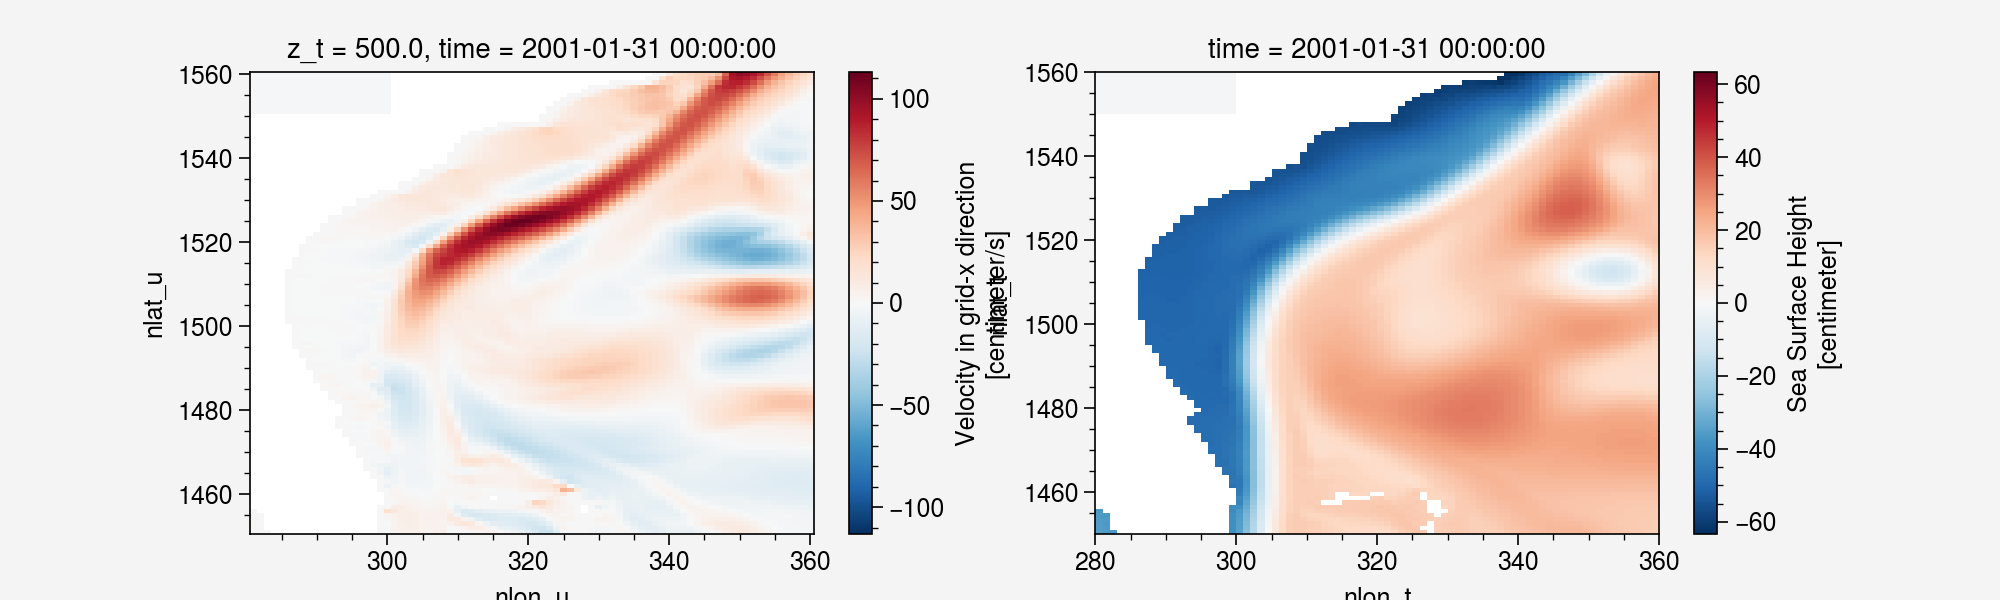

In [24]:
# select region (r)
# # --- US southeast coast region ---
nlat1_r_t12, nlat2_r_t12 = 1500-50, 1510+50
nlon1_r_t12, nlon2_r_t12 = 280, 360
# # ---------------------------------

uvel_r_TH = xds_uvel_TH.UVEL.isel(nlon_u=slice(nlon1_r_t12, nlon2_r_t12),
                                  nlat_u=slice(nlat1_r_t12, nlat2_r_t12))
ssh_r_TH = xds_ssh_TH.SSH.isel(nlon_t=slice(nlon1_r_t12, nlon2_r_t12),
                               nlat_t=slice(nlat1_r_t12, nlat2_r_t12))

uvel_r_CH = xds_uvel_CH.UVEL.isel(nlon_u=slice(nlon1_r_t12, nlon2_r_t12),
                                  nlat_u=slice(nlat1_r_t12, nlat2_r_t12))
ssh_r_CH = xds_ssh_CH.SSH.isel(nlon_t=slice(nlon1_r_t12, nlon2_r_t12),
                               nlat_t=slice(nlat1_r_t12, nlat2_r_t12))

# need kmu to mask land for contour plot
kmu_r_TH = xds_uvel_TH.KMU.isel(nlon_u=slice(nlon1_r_t12, nlon2_r_t12), nlat_u=slice(nlat1_r_t12, nlat2_r_t12))
kmt_r_TH = xds_uvel_TH.KMT.isel(nlon_t=slice(nlon1_r_t12, nlon2_r_t12), nlat_t=slice(nlat1_r_t12, nlat2_r_t12))
uarea_r_TH = xds_uvel_TH.UAREA.isel(nlon_u=slice(nlon1_r_t12, nlon2_r_t12), nlat_u=slice(nlat1_r_t12, nlat2_r_t12))
tarea_r_TH = xds_uvel_TH.TAREA.isel(nlon_t=slice(nlon1_r_t12, nlon2_r_t12), nlat_t=slice(nlat1_r_t12, nlat2_r_t12))
ulon_r_TH = xds_uvel_TH.ULONG.isel(nlon_u=slice(nlon1_r_t12, nlon2_r_t12), nlat_u=slice(nlat1_r_t12, nlat2_r_t12))
ulat_r_TH = xds_uvel_TH.ULAT.isel(nlon_u=slice(nlon1_r_t12, nlon2_r_t12), nlat_u=slice(nlat1_r_t12, nlat2_r_t12))

fig, axs = plt.subplots(1,2,figsize=(10,3))
uvel_r_TH.isel(time=0, z_t=0).plot(ax=axs[0])
ssh_r_TH.isel(time=0).plot(ax=axs[1])

ulon_r_TH.dims ('nlat_u', 'nlon_u')
ulon_r_TH.dims ('nlat_u', 'nlon_u')
-80.39999999999999 -80.47301757454053
26.774385702142727 32.77276903590433


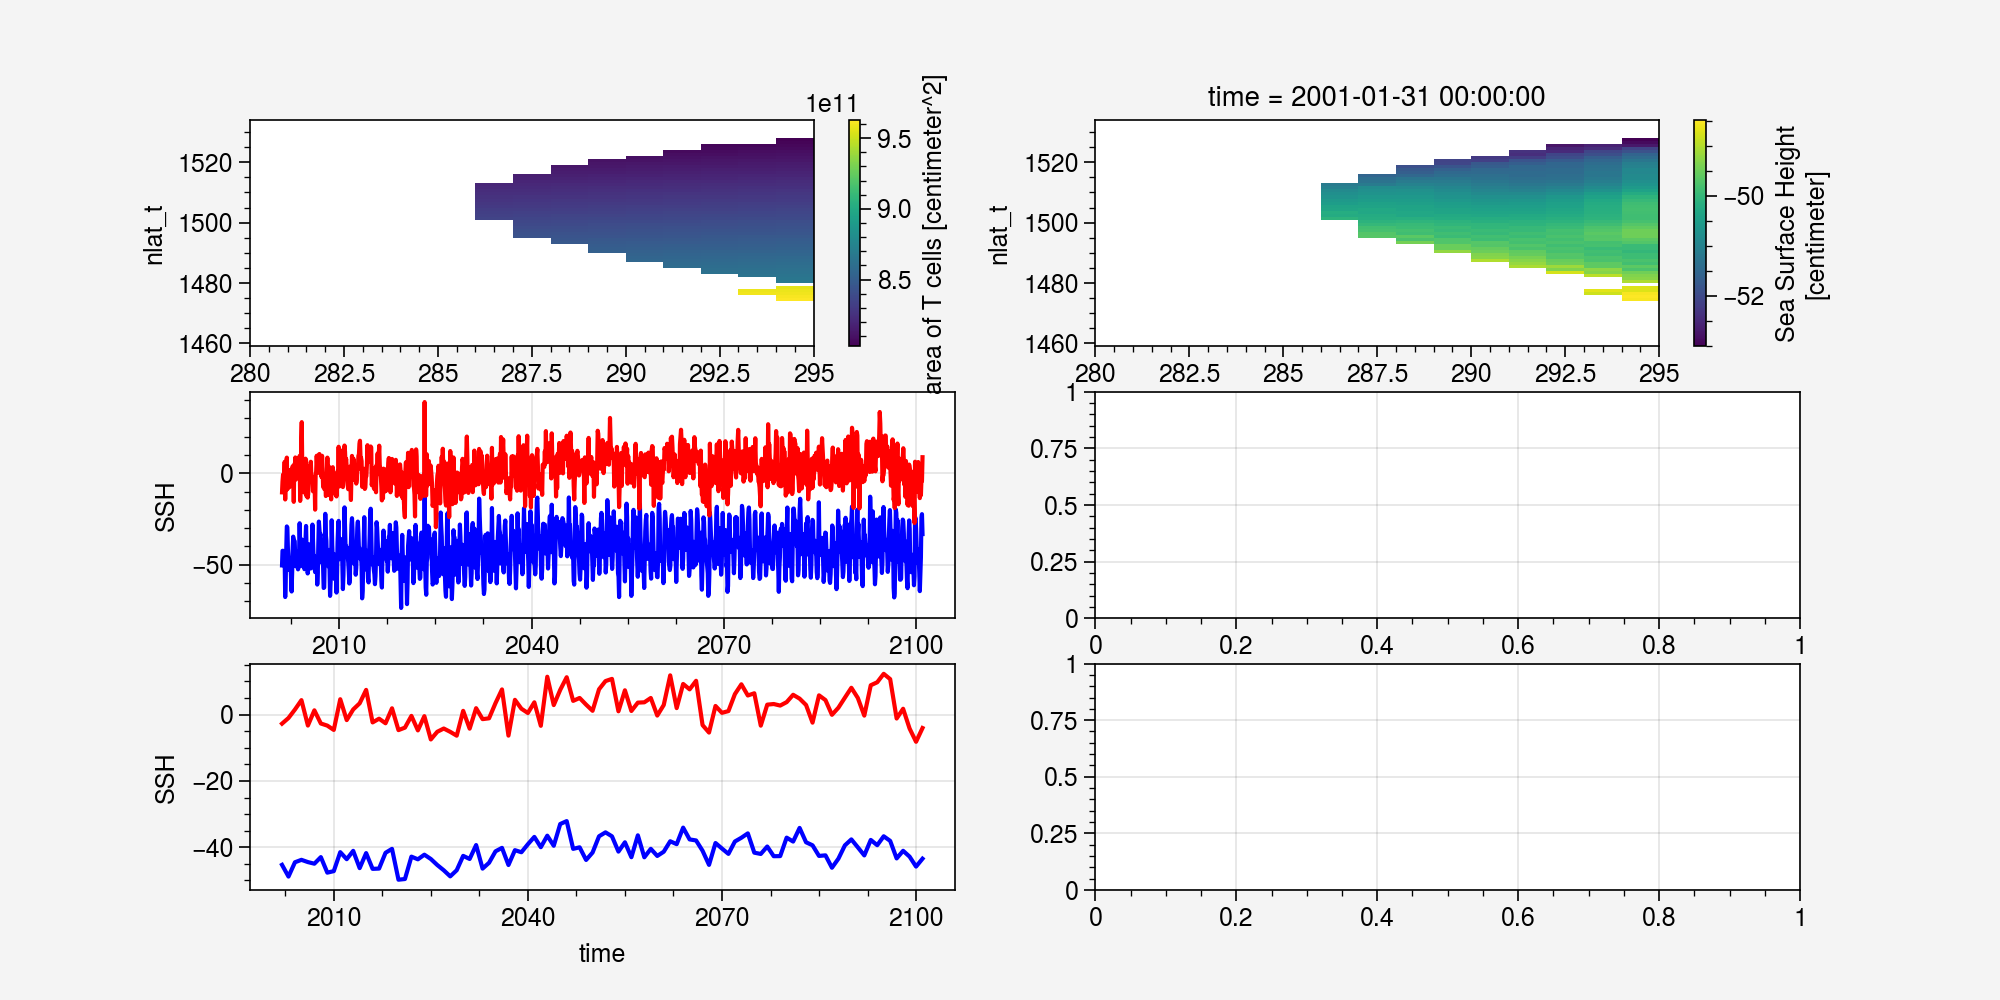

In [25]:
# --- select cross section (region 2) ---
nlat1_r2_t12 = 9
nlat2_r2_t12 = 84

nlon1_r2_t12 = 15


ssh_r2_TH = ssh_r_TH[:,nlat1_r2_t12:nlat2_r2_t12, 0:nlon1_r2_t12]
ssh_r2_CH = ssh_r_CH[:,nlat1_r2_t12:nlat2_r2_t12, 0:nlon1_r2_t12]

kmt_r2_TH = kmt_r_TH[nlat1_r2_t12:nlat2_r2_t12, 0:nlon1_r2_t12]
tarea_r2_TH = tarea_r_TH[nlat1_r2_t12:nlat2_r2_t12, 0:nlon1_r2_t12]

print('ulon_r_TH.dims', ulon_r_TH.dims)
ulon_cs_TH = ulon_r_TH[nlat1_r2_t12:nlat2_r2_t12, nlon1_r2_t12]
print('ulon_r_TH.dims', ulat_r_TH.dims)
ulat_cs_TH = ulat_r_TH[nlat1_r2_t12:nlat2_r2_t12, nlon1_r2_t12]
print(ulon_cs_TH.values[0], ulon_cs_TH.values[-1])
print(ulat_cs_TH.values[0], ulat_cs_TH.values[-1])
# --------------------------------------

# --- compute ssh spatial av ---
tarea_r2m_TH = tarea_r2_TH.where(kmt_r2_TH>0, np.nan)
ssh_r2m_TH = ssh_r2_TH.where(kmt_r2_TH>0, np.nan)
ssh_r2m_CH = ssh_r2_CH.where(kmt_r2_TH>0, np.nan)
# print(tarea_csbox_TH.dims)

tarea_r2msum_TH = tarea_r2m_TH.sum(('nlon_t','nlat_t')).values
ssh_r2msum_TH = (ssh_r2m_TH*tarea_r2m_TH.values).sum(('nlon_t','nlat_t'))
ssh_r2mav_TH = ssh_r2msum_TH/tarea_r2msum_TH
ssh_r2mav_TH = ssh_r2mav_TH.compute()

ssh_r2msum_CH = (ssh_r2m_CH*tarea_r2m_TH.values).sum(('nlon_t','nlat_t'))
ssh_r2mav_CH = ssh_r2msum_CH/tarea_r2msum_TH
ssh_r2mav_CH = ssh_r2mav_CH.compute()
# -------------------------------

fig, axs = plt.subplots(3,2,figsize=(10,5))
tarea_r2m_TH.plot(ax=axs[0,0])
ssh_r2m_TH.isel(time=0).plot(ax=axs[0,1])
ssh_r2mav_TH.plot(ax=axs[1,0],color='b')
(ssh_r2mav_TH-ssh_r2mav_CH.values).plot(ax=axs[1,0],color='r')
ssh_r2mav_TH.resample(time='A').mean('time').plot(ax=axs[2,0],color='b')
(ssh_r2mav_TH-ssh_r2mav_CH.values).resample(time='A').mean('time').plot(ax=axs[2,0],color='r')

q_cs_TH.dims ('time', 'z_t', 'nlat_u')


array([   0.,    0.,    0.,    0.,    0.,    0., 3000., 3000., 3000.,
       3000., 3000., 3000., 3000., 3000., 3000.])

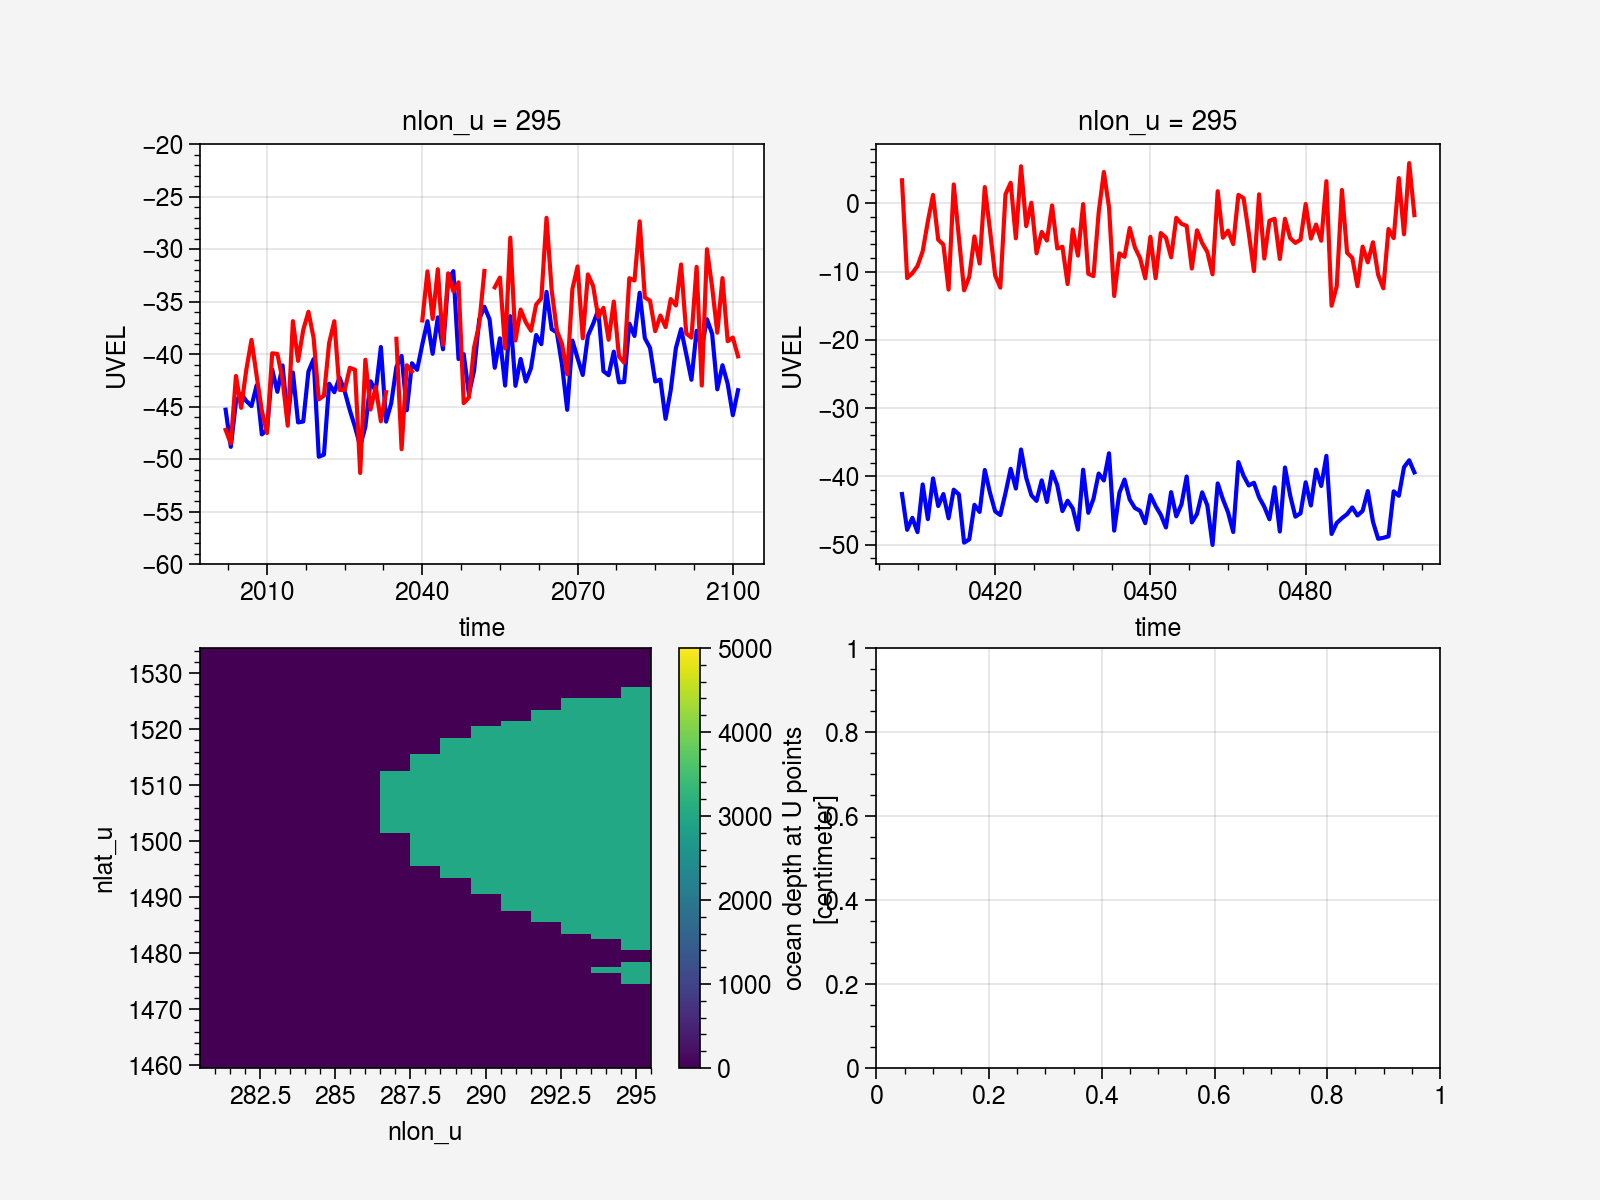

In [26]:
# compute ssh from velocity integration
dyu_r_TH = xds_uvel_TH.DYU.isel(nlon_u=slice(nlon1_r_t12, nlon2_r_t12), nlat_u=slice(nlat1_r_t12, nlat2_r_t12))
dzu_r_TH = xds_uvel_TH.DZU.isel(nlon_u=slice(nlon1_r_t12, nlon2_r_t12), nlat_u=slice(nlat1_r_t12, nlat2_r_t12))
HU_r_TH = xds_uvel_TH.HU.isel(nlon_u=slice(nlon1_r_t12, nlon2_r_t12), nlat_u=slice(nlat1_r_t12, nlat2_r_t12))
HU_r2_TH = HU_r_TH[nlat1_r2_t12:nlat2_r2_t12, 0:nlon1_r2_t12]


uvel_cs_TH = uvel_r_TH[:,:,nlat1_r2_t12:nlat2_r2_t12, nlon1_r2_t12-1]
uvel_cs_CH = uvel_r_CH[:,:,nlat1_r2_t12:nlat2_r2_t12, nlon1_r2_t12-1]
# print('uvel_cs_TH.dims', uvel_cs_TH.dims)
dyu_cs_TH = dyu_r_TH[nlat1_r2_t12:nlat2_r2_t12, nlon1_r2_t12-1]
# print('dyu_cs_TH.dims', dyu_cs_TH.dims)
dzu_cs_TH = dzu_r_TH[:,nlat1_r2_t12:nlat2_r2_t12, nlon1_r2_t12-1]
# print('dzu_cs_TH.dims', dzu_cs_TH.dims)
q_cs_TH = uvel_cs_TH*dyu_cs_TH.values*dzu_cs_TH.fillna(0).values
q_cs_CH = uvel_cs_CH*dyu_cs_TH.values*dzu_cs_TH.fillna(0).values
print('q_cs_TH.dims', q_cs_TH.dims)
Q_cs_TH = q_cs_TH.sum(('nlat_u','z_t'))
Q_cs_TH = Q_cs_TH.compute()
Q_cs_CH = q_cs_CH.sum(('nlat_u','z_t'))
Q_cs_CH = Q_cs_CH.compute()
Q_cs_TH

# sec_in_month = Q_cs_TH.time.dt.days_in_month.values*86400
T_cs_TH = -Q_cs_TH*(Q_cs_TH.time.dt.days_in_month.values*86400)
T_cs_CH = -Q_cs_CH*(Q_cs_CH.time.dt.days_in_month.values*86400)

ssh_u_csbox_TH = T_cs_TH.cumsum('time')/tarea_r2msum_TH
ssh_u_csbox_CH = T_cs_CH.cumsum('time')/tarea_r2msum_TH

fig, axs = plt.subplots(2,2,figsize=(8,6))

(ssh_r2mav_TH.resample(time='A').mean('time')).plot(ax=axs[0,0], color='b')
(ssh_u_csbox_TH.sel(time=slice('2001','2032')).resample(time='A').mean('time')-62).plot(ax=axs[0,0], color='r')
(ssh_u_csbox_TH.sel(time=slice('2034','2037')).resample(time='A').mean('time')-80).plot(ax=axs[0,0], color='r')
(ssh_u_csbox_TH.sel(time=slice('2039','2051')).resample(time='A').mean('time')-60).plot(ax=axs[0,0], color='r')
(ssh_u_csbox_TH.sel(time=slice('2053','2100')).resample(time='A').mean('time')-75).plot(ax=axs[0,0], color='r')
axs[0,0].set_ylim([-60,-20])

(ssh_r2mav_CH.resample(time='A').mean('time')).plot(ax=axs[0,1], color='b')
(ssh_u_csbox_CH).resample(time='A').mean('time').plot(ax=axs[0,1], color='r')

HU_r2_TH.plot(ax=axs[1,0], vmin=0,vmax=50*100)
HU_r2_TH.isel(nlat_u=50).values

In [27]:
# ssh_u_csbox_THmCH = ssh_u_csbox_TH - ssh_u_csbox_CH.values
# ssh_u_csbox_tre_THmCH = ssh_u_csbox_THmCH.resample(time='A').mean('time')

# ssh_r2mav_THmCH.sel(time=slice('2001','2020')).mean('time').values, ssh_u_csbox_tre_c_THmCH.sel(time=slice('2001','2020')).mean('time').values
# fig, axs = plt.subplots(1,3,figsize=(10,3))
# (ssh_u_csbox_CH).resample(time='A').mean('time').plot(ax=axs[0], color='b')
# (ssh_u_csbox_TH).resample(time='A').mean('time').plot(ax=axs[1], color='r')

# ssh_u_csbox_tre_THmCH = ssh_u_csbox_THmCH.resample(time='A').mean('time')
# (ssh_u_csbox_tre_THmCH).resample(time='A').mean('time').plot(ax=axs[2], color='r')

# ssh_u_avdif_THmCH = ssh_u_csbox_tre_THmCH.sel(time=slice('2001','2020')).mean('time').values - ssh_r2mav_THmCH.sel(time=slice('2001','2020')).mean('time').values
# ssh_u_avdif_THmCH

In [28]:
# ssh_u_csbox_tre_c_THmCH = ssh_u_csbox_tre_THmCH - ssh_u_avdif_THmCH
# print(ssh_u_csbox_tre_c_THmCH[32].values, ssh_r2mav_THmCH[32].values)
# print(ssh_u_csbox_tre_c_THmCH[51].values, ssh_r2mav_THmCH[51].values)
# ssh_u_csbox_tre_c_THmCH[32:37] = ssh_u_csbox_tre_c_THmCH[32:37]-(ssh_u_csbox_tre_c_THmCH[32].values - ssh_r2mav_THmCH[32].values)
# ssh_u_csbox_tre_c_THmCH[51:] = ssh_u_csbox_tre_c_THmCH[51:]-(ssh_u_csbox_tre_c_THmCH[53].values - ssh_r2mav_THmCH[53].values)

# fig, axs = plt.subplots(1,2,figsize=(10,3))
# ssh_r2mav_tre_THmCH.plot(ax=axs[0], linewidth=0.5, color='b')
# ssh_r2mav_tre_THmCH.rolling(time=10, center=True).mean('time').plot(ax=axs[0], linewidth=2, color='b')
# # (ssh_u_csbox_tre_THmCH-30).plot(linewidth=0.5, color='m')
# (ssh_u_csbox_tre_c_THmCH).plot(ax=axs[0], linewidth=0.5, color='r')
# (ssh_u_csbox_tre_c_THmCH).rolling(time=10, center=True).mean('time').plot(ax=axs[0], linewidth=2, color='r')
# axs[0].set_ylim([-20,25])

In [29]:
# # 1. correct for mean ssh and vel integration difference
# ssh_u_avdif_THmCH = ssh_u_csbox_tre_THmCH.sel(time=slice('2001','2020')).mean('time').values - ssh_r2mav_THmCH.sel(time=slice('2001','2020')).mean('time').values
# ssh_u_csbox_tre_c_THmCH = ssh_u_csbox_tre_THmCH - ssh_u_avdif_THmCH
# # 2. correct for missing time stamps
# # TH miss 203307, 203809, 205211, CH has no miss
# print(ssh_u_csbox_tre_c_THmCH.time[32].values, ssh_u_csbox_tre_c_THmCH.time[37].values, ssh_u_csbox_tre_c_THmCH.time[51].values)
# ssh_u_csbox_tre_c_THmCH[32:37] = ssh_u_csbox_tre_c_THmCH[32:37]-(ssh_u_csbox_tre_c_THmCH[32].values - ssh_r2mav_THmCH[32].values)
# ssh_u_csbox_tre_c_THmCH[51:] = ssh_u_csbox_tre_c_THmCH[51:]-(ssh_u_csbox_tre_c_THmCH[51].values - ssh_r2mav_THmCH[51].values)
# fig, axs = plt.subplots(1,2,figsize=(10,3))
# ssh_r2mav_tre_THmCH.plot(ax=axs[0], linewidth=0.5, color='b')
# ssh_r2mav_tre_THmCH.rolling(time=10, center=True).mean('time').plot(ax=axs[0], linewidth=2, color='b')
# # (ssh_u_csbox_tre_THmCH-30).plot(linewidth=0.5, color='m')
# (ssh_u_csbox_tre_c_THmCH).plot(ax=axs[0], linewidth=0.5, color='r')
# (ssh_u_csbox_tre_c_THmCH).rolling(time=10, center=True).mean('time').plot(ax=axs[0], linewidth=2, color='r')
# axs[0].set_ylim([-20,25])

26.287109147255556
2033-12-31 00:00:00 2038-12-31 00:00:00 2052-12-31 00:00:00


(-20.0, 25.0)

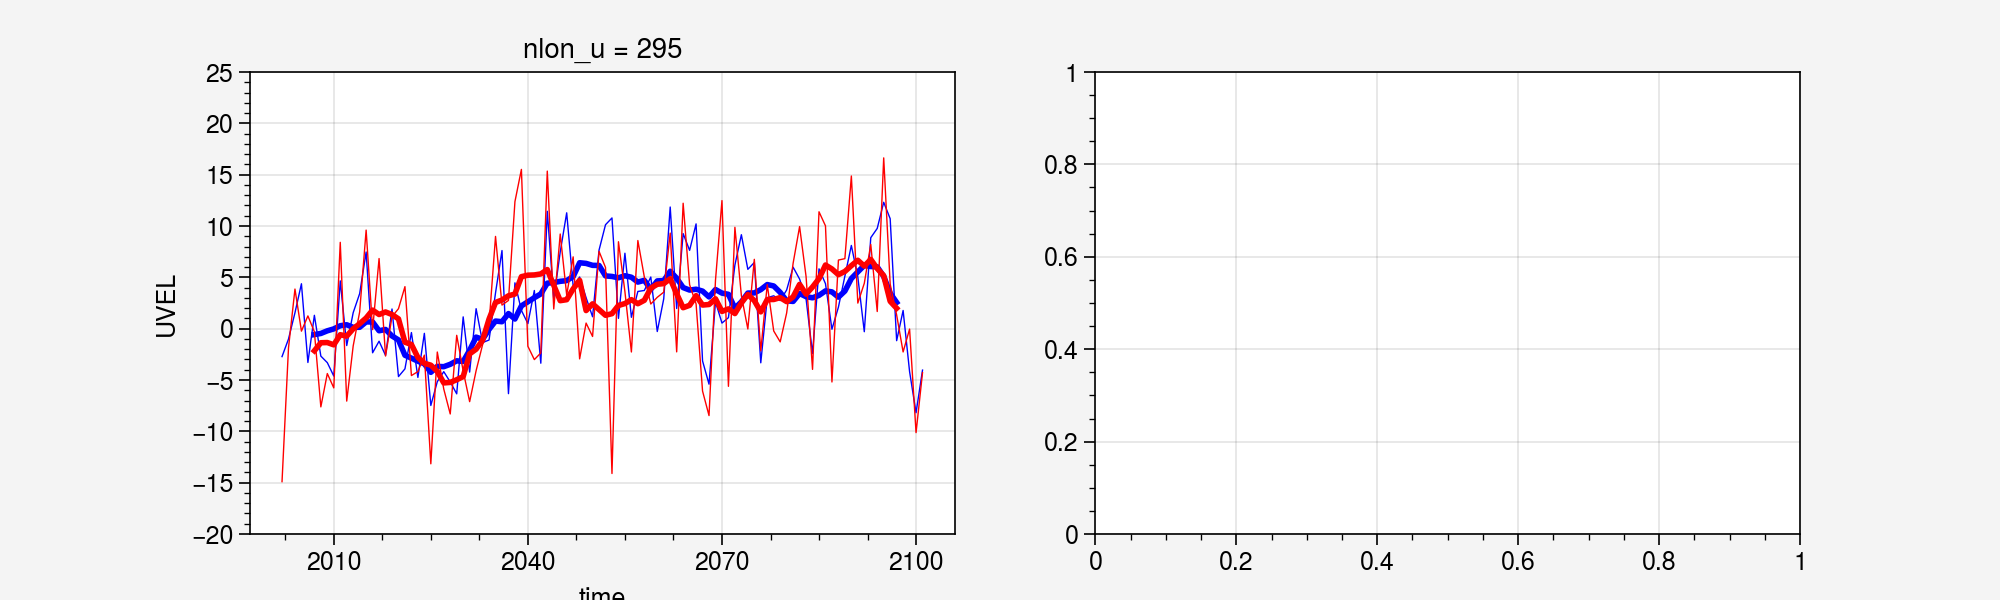

In [30]:
ssh_r2mav_THmCH = ssh_r2mav_TH - ssh_r2mav_CH.values
ssh_r2mav_tre_THmCH = ssh_r2mav_THmCH.resample(time='A').mean('time')

ssh_u_csbox_THmCH = ssh_u_csbox_TH - ssh_u_csbox_CH.values
ssh_u_csbox_tre_THmCH = ssh_u_csbox_THmCH.resample(time='A').mean('time')

ssh_u_csbox_tre_c_THmCH = ssh_u_csbox_tre_THmCH 

# 1. correct for mean difference between ssh and ssh(u)
ssh_sshu_avdif_THmCH = ssh_u_csbox_tre_THmCH.sel(time=slice('2001','2020')).mean('time').values - ssh_r2mav_THmCH.sel(time=slice('2001','2020')).mean('time').values
print(ssh_sshu_avdif_THmCH)
ssh_u_csbox_tre_c_THmCH = ssh_u_csbox_tre_THmCH - ssh_sshu_avdif_THmCH

# 2. correct for missing time stamps, TH miss 203307, 203809, 205211, CH has no miss
print(ssh_u_csbox_tre_c_THmCH.time[32].values, ssh_u_csbox_tre_c_THmCH.time[37].values, ssh_u_csbox_tre_c_THmCH.time[51].values)
ssh_u_csbox_tre_c_THmCH[32:37] = ssh_u_csbox_tre_c_THmCH[32:37]-10 # manuall move it to be close to ssh time series by visually examing
ssh_u_csbox_tre_c_THmCH[51:] = ssh_u_csbox_tre_c_THmCH[51:]-14.5 # manuall move it to be close to ssh time series by visually examing


fig, axs = plt.subplots(1,2,figsize=(10,3))
ssh_r2mav_tre_THmCH.plot(ax=axs[0], linewidth=0.5, color='b')
ssh_r2mav_tre_THmCH.rolling(time=10, center=True).mean('time').plot(ax=axs[0], linewidth=2, color='b')
# (ssh_u_csbox_tre_THmCH-30).plot(linewidth=0.5, color='m')
(ssh_u_csbox_tre_c_THmCH).plot(ax=axs[0], linewidth=0.5, color='r')
(ssh_u_csbox_tre_c_THmCH).rolling(time=10, center=True).mean('time').plot(ax=axs[0], linewidth=2, color='r')
axs[0].set_ylim([-20,25])

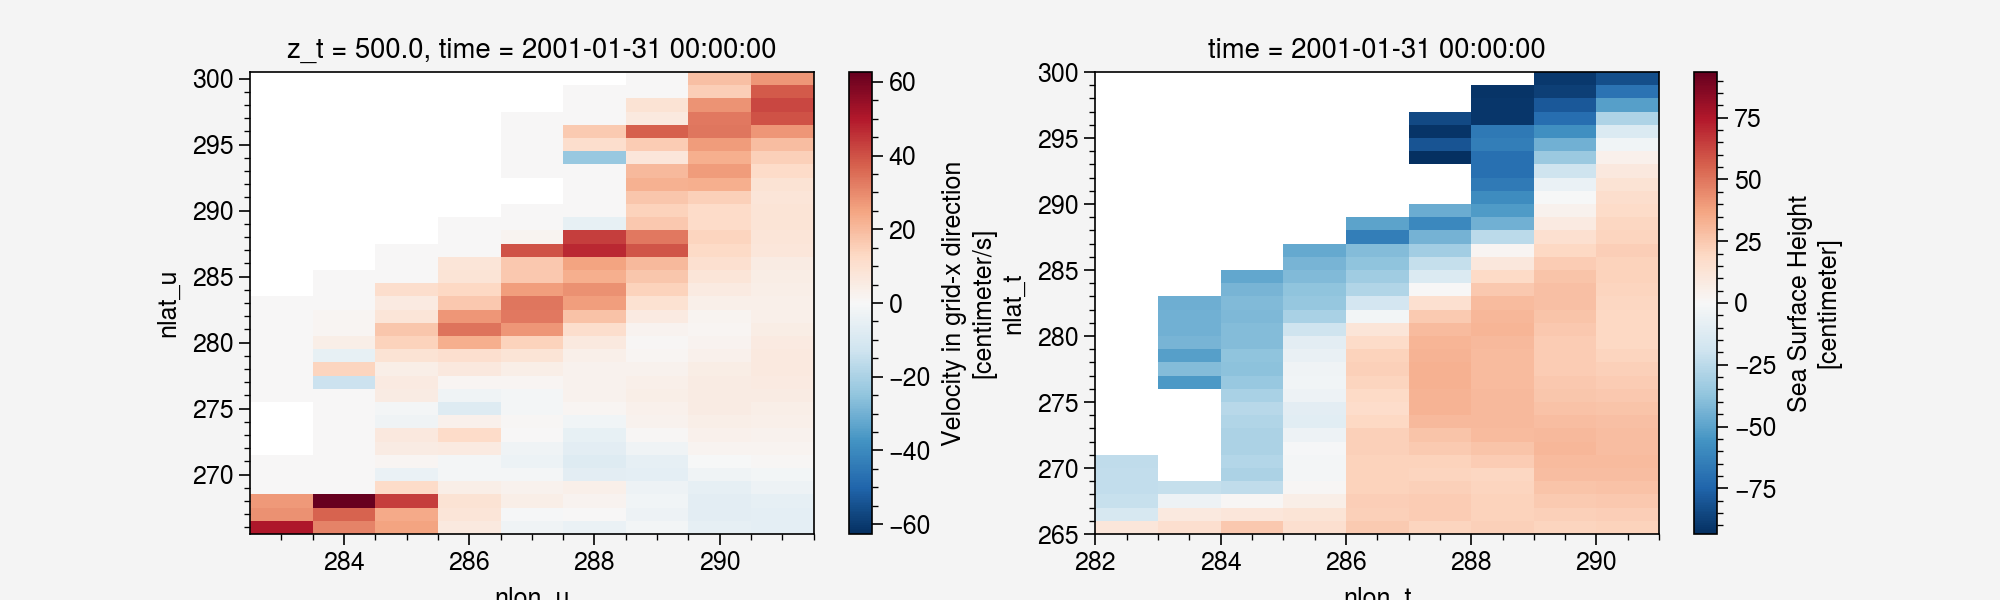

In [31]:
# select region (r)
nlon1_r_g16, nlon2_r_g16 = 260+22, 321-30
nlat1_r_g16, nlat2_r_g16 = 230+35, 350-50

uvel_r_TL = xds_uvel_TL.UVEL.isel(nlon_u=slice(nlon1_r_g16, nlon2_r_g16),
                                  nlat_u=slice(nlat1_r_g16, nlat2_r_g16))
ssh_r_TL = xds_ssh_TL.SSH.isel(nlon_t=slice(nlon1_r_g16, nlon2_r_g16),
                               nlat_t=slice(nlat1_r_g16, nlat2_r_g16))

uvel_r_CL = xds_uvel_CL.UVEL.isel(nlon_u=slice(nlon1_r_g16, nlon2_r_g16),
                                  nlat_u=slice(nlat1_r_g16, nlat2_r_g16))
ssh_r_CL = xds_ssh_CL.SSH.isel(nlon_t=slice(nlon1_r_g16, nlon2_r_g16),
                               nlat_t=slice(nlat1_r_g16, nlat2_r_g16))

# need kmu to mask land for contour plot
kmu_r_TL = xds_uvel_TL.KMU.isel(nlon_u=slice(nlon1_r_g16, nlon2_r_g16), nlat_u=slice(nlat1_r_g16, nlat2_r_g16))
kmt_r_TL = xds_uvel_TL.KMT.isel(nlon_t=slice(nlon1_r_g16, nlon2_r_g16), nlat_t=slice(nlat1_r_g16, nlat2_r_g16))
uarea_r_TL = xds_uvel_TL.UAREA.isel(nlon_u=slice(nlon1_r_g16, nlon2_r_g16), nlat_u=slice(nlat1_r_g16, nlat2_r_g16))
tarea_r_TL = xds_uvel_TL.TAREA.isel(nlon_t=slice(nlon1_r_g16, nlon2_r_g16), nlat_t=slice(nlat1_r_g16, nlat2_r_g16))
ulon_r_TL = xds_uvel_TL.ULONG.isel(nlon_u=slice(nlon1_r_g16, nlon2_r_g16), nlat_u=slice(nlat1_r_g16, nlat2_r_g16))
ulat_r_TL = xds_uvel_TL.ULAT.isel(nlon_u=slice(nlon1_r_g16, nlon2_r_g16), nlat_u=slice(nlat1_r_g16, nlat2_r_g16))


fig, axs = plt.subplots(1,2,figsize=(10,3))
uvel_r_TL.isel(time=0, z_t=0).plot(ax=axs[0])
ssh_r_TL.isel(time=0).plot(ax=axs[1])

ulon_r_TL.dims ('nlat_u', 'nlon_u')
ulon_r_TL.dims ('nlat_u', 'nlon_u')
-79.16505564815657 -78.94371825401583
27.8278766245166 33.953207981526525


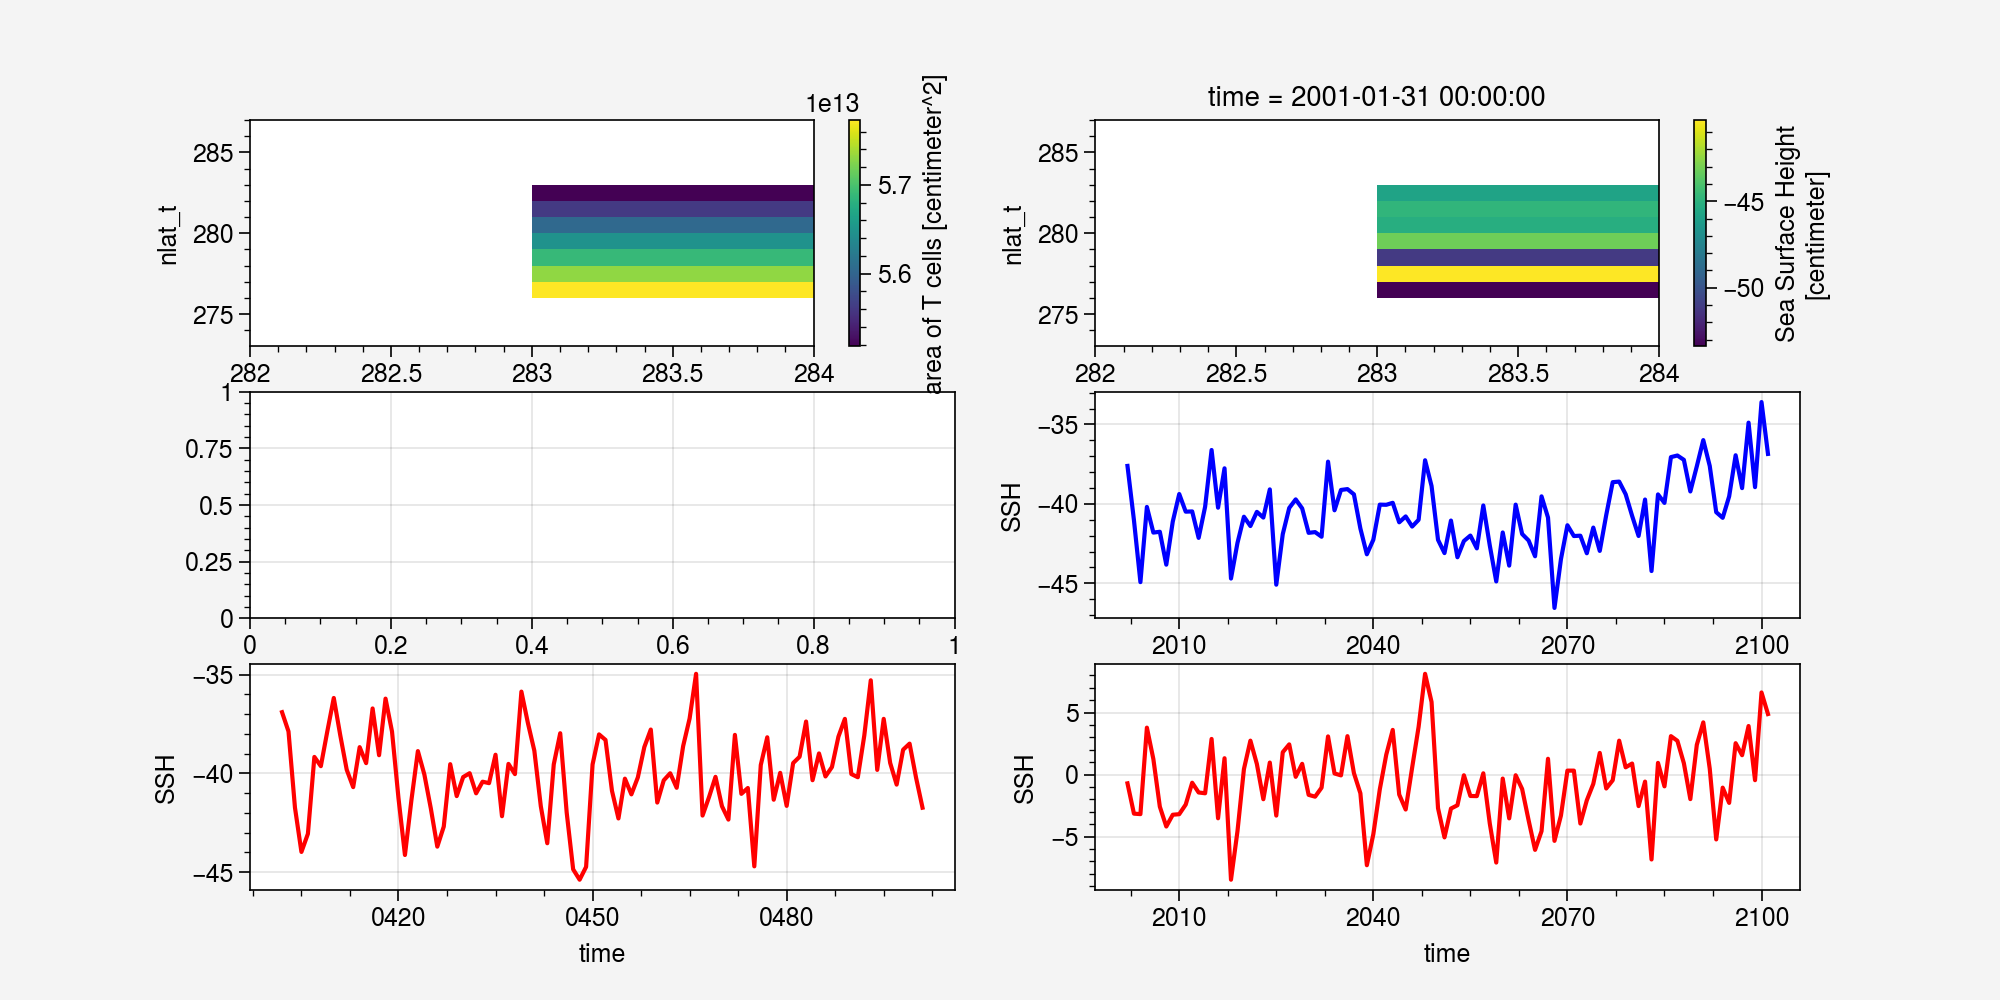

In [32]:
# select box region (r2)
nlat1_r2_g16, nlat2_r2_g16 = 8, 22
nlon1_r2_g16 = 2


print('ulon_r_TL.dims', ulon_r_TL.dims)
ulon_cs_TL = ulon_r_TL[nlat1_r2_g16:nlat2_r2_g16, nlon1_r2_g16]
print('ulon_r_TL.dims', ulat_r_TL.dims)
ulat_cs_TL = ulat_r_TL[nlat1_r2_g16:nlat2_r2_g16, nlon1_r2_g16]
print(ulon_cs_TL.values[0]-360, ulon_cs_TL.values[-1]-360)
print(ulat_cs_TL.values[0], ulat_cs_TL.values[-1])

# --- compute ssh regional av ---
ssh_r2_TL = ssh_r_TL[:,nlat1_r2_g16:nlat2_r2_g16, 0:nlon1_r2_g16]
ssh_r2_CL = ssh_r_CL[:,nlat1_r2_g16:nlat2_r2_g16, 0:nlon1_r2_g16]

kmt_r2_TL = kmt_r_TL[nlat1_r2_g16:nlat2_r2_g16, 0:nlon1_r2_g16]
tarea_r2_TL = tarea_r_TL[nlat1_r2_g16:nlat2_r2_g16, 0:nlon1_r2_g16]
tarea_r2m_TL = tarea_r2_TL.where(kmt_r2_TL>0, np.nan)
ssh_r2m_TL = ssh_r2_TL.where(kmt_r2_TL>0, np.nan)
ssh_r2m_CL = ssh_r2_CL.where(kmt_r2_TL>0, np.nan)
# print(tarea_csbox_TL.dims)

tarea_r2msum_TL = tarea_r2m_TL.sum(('nlon_t','nlat_t')).values
ssh_r2msum_TL = (ssh_r2m_TL*tarea_r2m_TL.values).sum(('nlon_t','nlat_t'))
ssh_r2mav_TL = ssh_r2msum_TL/tarea_r2msum_TL
ssh_r2mav_TL = ssh_r2mav_TL.compute()

ssh_r2msum_CL = (ssh_r2m_CL*tarea_r2m_TL.values).sum(('nlon_t','nlat_t'))
ssh_r2mav_CL = ssh_r2msum_CL/tarea_r2msum_TL
ssh_r2mav_CL = ssh_r2mav_CL.compute()
# ---------------------------------

fig, axs = plt.subplots(3,2,figsize=(10,5))
tarea_r2m_TL.plot(ax=axs[0,0])
ssh_r2m_TL.isel(time=0).plot(ax=axs[0,1])
# ssh_r2mav_TL.plot(ax=axs[1,0],color='r')
(ssh_r2mav_TL.resample(time='A').mean('time')).plot(ax=axs[1,1],color='b')
ssh_r2mav_CL.resample(time='A').mean('time').plot(ax=axs[2,0],color='r')
(ssh_r2mav_TL.resample(time='A').mean('time')-ssh_r2mav_CL.resample(time='A').mean('time').values).plot(ax=axs[2,1],color='r')

q_cs_TL.dims ('time', 'z_t', 'nlat_u')


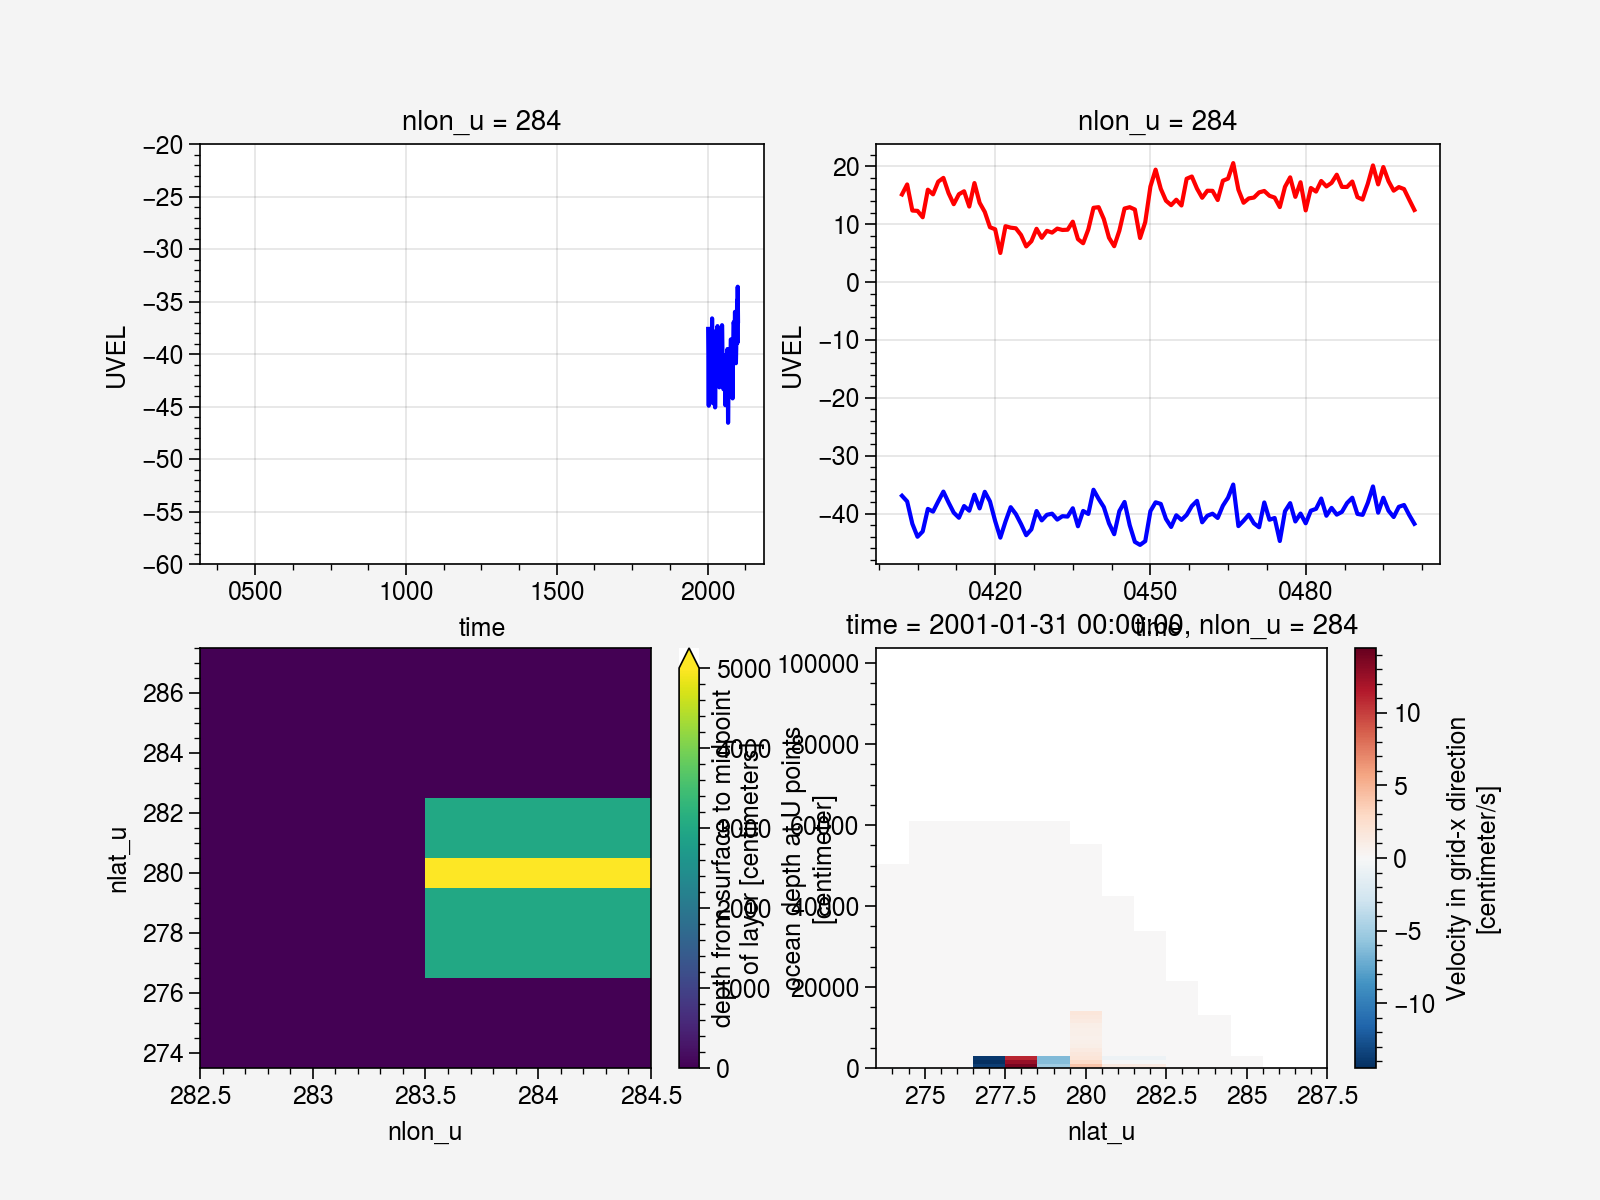

In [33]:
# compute ssh from velocity integration
dyu_r_TL = xds_uvel_TL.DYU.isel(nlon_u=slice(nlon1_r_g16, nlon2_r_g16), nlat_u=slice(nlat1_r_g16, nlat2_r_g16))
dzu_r_TL = xds_uvel_TL.DZU.isel(nlon_u=slice(nlon1_r_g16, nlon2_r_g16), nlat_u=slice(nlat1_r_g16, nlat2_r_g16))
HU_r_TL = xds_uvel_TL.HU.isel(nlon_u=slice(nlon1_r_g16, nlon2_r_g16), nlat_u=slice(nlat1_r_g16, nlat2_r_g16))
HU_r2_TL = HU_r_TL[nlat1_r2_g16:nlat2_r2_g16, 0:nlon1_r2_g16]


uvel_cs_TL = uvel_r_TL[:,:,nlat1_r2_g16:nlat2_r2_g16, nlon1_r2_g16-1]
uvel_cs_CL = uvel_r_CL[:,:,nlat1_r2_g16:nlat2_r2_g16, nlon1_r2_g16-1]
# print('uvel_cs_TL.dims', uvel_cs_TL.dims)
dyu_cs_TL = dyu_r_TL[nlat1_r2_g16:nlat2_r2_g16, nlon1_r2_g16-1]
# print('dyu_cs_TL.dims', dyu_cs_TL.dims)
dzu_cs_TL = dzu_r_TL[:,nlat1_r2_g16:nlat2_r2_g16, nlon1_r2_g16-1]
# print('dzu_cs_TL.dims', dzu_cs_TL.dims)
q_cs_TL = uvel_cs_TL*dyu_cs_TL.values*dzu_cs_TL.fillna(0).values
q_cs_CL = uvel_cs_CL*dyu_cs_TL.values*dzu_cs_TL.fillna(0).values
print('q_cs_TL.dims', q_cs_TL.dims)
Q_cs_TL = q_cs_TL.sum(('nlat_u','z_t'))
Q_cs_TL = Q_cs_TL.compute()
Q_cs_CL = q_cs_CL.sum(('nlat_u','z_t'))
Q_cs_CL = Q_cs_CL.compute()
Q_cs_TL

# sec_in_month = Q_cs_TL.time.dt.days_in_month.values*86400
# T_cs_TL = -Q_cs_TL*sec_in_month
# T_cs_CL = -Q_cs_CL*sec_in_month
# sec_in_month = Q_cs_TL.time.dt.days_in_month.values*86400
T_cs_TL = -Q_cs_TL*(Q_cs_TL.time.dt.days_in_month.values*86400)
T_cs_CL = -Q_cs_CL*(Q_cs_CL.time.dt.days_in_month.values*86400)

# # T_cs_TL[0]=0
# ssh_u_csbox_TL = T_cs_TL.cumsum('time')/tarea_r2msum_TL

# ssh_u_csbox_TL.plot(color='b')
# ssh_u_csbox_TL.resample(time='A').mean('time').plot(color='r')

# # correct for missing time
# # CESM-TNST HR Ens#1 has missing time: 2033-07, 2038-09, 2052-11
# print(T_cs_TL.sel(time='2033-07').values, T_cs_TL.sel(time='2038-09').values, T_cs_TL.sel(time='2052-11').values)
# # ssh_csbox_xysum_TL.sel(time='2033-07').values, ssh_csbox_xysum_TL.sel(time='2033-08').values

# T_cs_TL.sel(time='2033-07')
# T_cs_cr1_TL = xr.where(T_cs_TL.time == T_cs_TL.sel(time='2033-07').time.values, -T_cs_203307_TL, T_cs_TL)
# T_cs_cr2_TL = xr.where(T_cs_TL.time == T_cs_TL.sel(time='2038-09').time.values, -T_cs_203809_TL, T_cs_cr1_TL)
# T_cs_cr3_TL = xr.where(T_cs_TL.time == T_cs_TL.sel(time='2052-11').time.values, -T_cs_205211_TL, T_cs_cr2_TL)

# print(T_cs_203307_TL, T_cs_203809_TL, T_cs_205211_TL)
# print(T_cs_cr3_TL.sel(time='2033-07').values, T_cs_cr3_TL.sel(time='2033-07').values, T_cs_cr3_TL.sel(time='2033-07').values)

# ssh_u_csbox_TL = T_cs_cr3_TL.cumsum('time')/tarea_r2msum_TL
ssh_u_csbox_TL = T_cs_TL.cumsum('time')/tarea_r2msum_TL
ssh_u_csbox_CL = T_cs_CL.cumsum('time')/tarea_r2msum_TL

# ssh_u_csbox_TL.resample(time='A').mean('time').plot(color='r')
fig, axs = plt.subplots(2,2,figsize=(8,6))

(ssh_r2mav_TL.resample(time='A').mean('time')).plot(ax=axs[0,0], color='b')
(ssh_u_csbox_CL).resample(time='A').mean('time').plot(ax=axs[0,0], color='r')
# (ssh_u_csbox_TL.sel(time=slice('2001','2032')).resample(time='A').mean('time')-62).plot(ax=axs[0,0], color='r')
# (ssh_u_csbox_TL.sel(time=slice('2034','2037')).resample(time='A').mean('time')-80).plot(ax=axs[0,0], color='r')
# (ssh_u_csbox_TL.sel(time=slice('2039','2051')).resample(time='A').mean('time')-60).plot(ax=axs[0,0], color='r')
# (ssh_u_csbox_TL.sel(time=slice('2053','2100')).resample(time='A').mean('time')-75).plot(ax=axs[0,0], color='r')
axs[0,0].set_ylim([-60,-20])

(ssh_r2mav_CL.resample(time='A').mean('time')).plot(ax=axs[0,1], color='b')
(ssh_u_csbox_CL).resample(time='A').mean('time').plot(ax=axs[0,1], color='r')

HU_r2_TL.plot(ax=axs[1,0], vmin=0,vmax=50*100)
# HU_r2_TL.isel(nlat_u=50).values

uvel_cs_TL.isel(time=0).sel(z_t=slice(0,1000*100)).plot(ax=axs[1,1])
# uvel_cs_TL

-17.86025523917451
2014-12-31 00:00:00 2017-12-31 00:00:00 2045-12-31 00:00:00


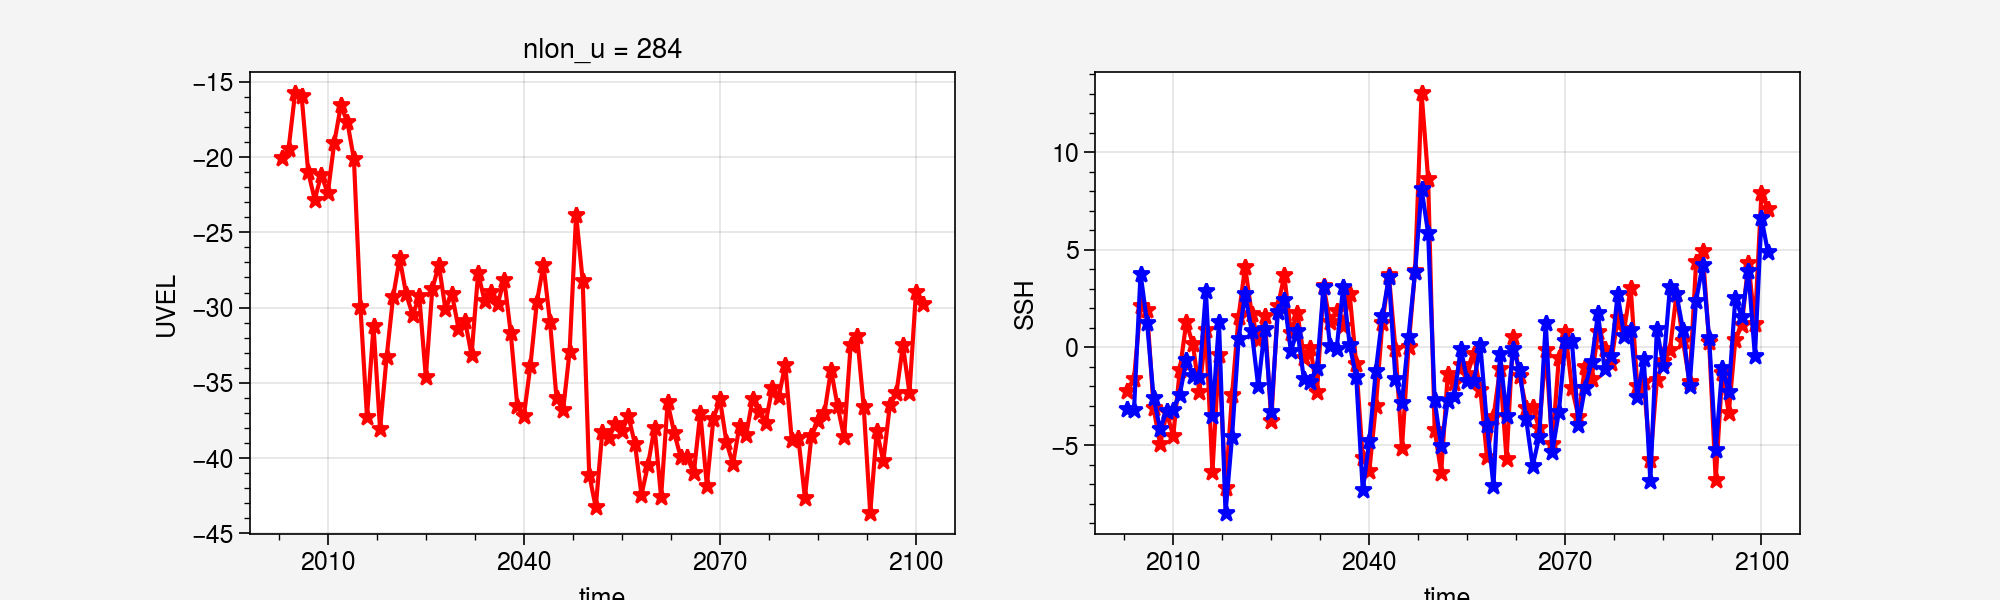

In [34]:
ssh_u_csbox_tre_TL = ssh_u_csbox_TL.resample(time='A').mean('time')
ssh_u_csbox_tre_CL = ssh_u_csbox_CL.resample(time='A').mean('time')
ssh_u_csbox_tre_TLmCL = ssh_u_csbox_tre_TL - ssh_u_csbox_tre_CL.values

ssh_r2mav_tre_TL = ssh_r2mav_TL.resample(time='A').mean('time')
ssh_r2mav_tre_CL = ssh_r2mav_CL.resample(time='A').mean('time').values
ssh_r2mav_tre_TLmCL = ssh_r2mav_tre_TL - ssh_r2mav_tre_CL

# 1. correct for mean difference between ssh and ssh(u)
ssh_sshu_avdif_TLmCL = ssh_u_csbox_tre_TLmCL.sel(time=slice('2002','2010')).mean('time').values - ssh_r2mav_tre_TLmCL.sel(time=slice('2002','2010')).mean('time').values
print(ssh_sshu_avdif_TLmCL)
ssh_u_csbox_tre_c_TLmCL = ssh_u_csbox_tre_TLmCL - ssh_sshu_avdif_TLmCL

# 2. correct for missing time stamps
# === LR ===
# CESM-TNST LR miss 2014-Jan (2014-02-01 monthly file) from time series file
# CESM-CTRL LR miss 0374-09, 0398-12, 0401-11, 0417-02, 0445-06,  from time series file 
#                                     2001-11, 2017-02, 2045-06 

print(ssh_u_csbox_tre_c_TLmCL.time[13].values, ssh_u_csbox_tre_c_TLmCL.time[16].values, ssh_u_csbox_tre_c_TLmCL.time[44].values)
ssh_u_csbox_tre_c_TLmCL[13:16] = ssh_u_csbox_tre_c_TLmCL[13:16]+13
ssh_u_csbox_tre_c_TLmCL[16:44] = ssh_u_csbox_tre_c_TLmCL[16:44]+13
ssh_u_csbox_tre_c_TLmCL[44:] = ssh_u_csbox_tre_c_TLmCL[44:]+19


fig, axs = plt.subplots(1,2,figsize=(10,3))
(ssh_u_csbox_tre_TLmCL[1:]).plot(ax=axs[0], color='r',marker='*')
# ssh_r2mav_tre_TLmCL[1:].plot(ax=axs[0], color='b',marker='*')
(ssh_u_csbox_tre_c_TLmCL[1:]).plot(ax=axs[1], color='r',marker='*')
ssh_r2mav_tre_TLmCL[1:].plot(ax=axs[1], color='b',marker='*')

# make pics

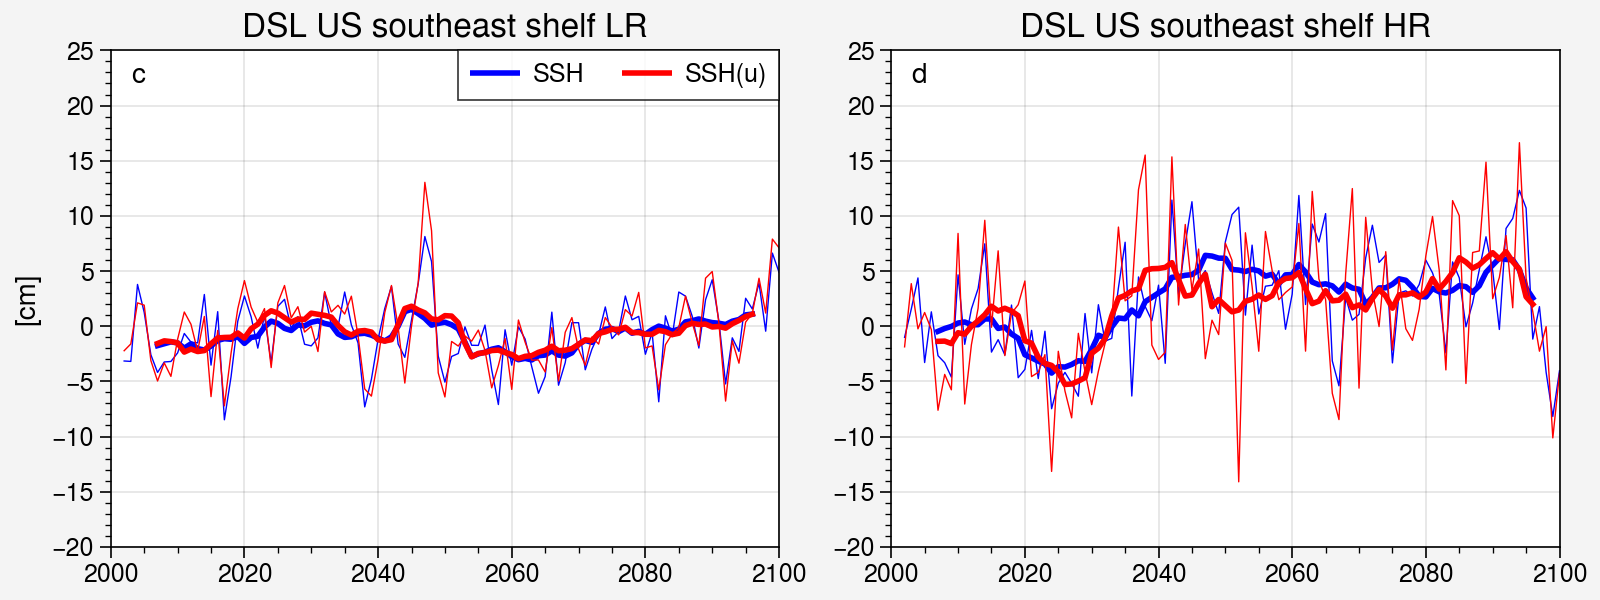

In [35]:
fig1, axs = plot.subplots(nrows=1, ncols=2, width='8in',height='3in', sharex=False, sharey=False)
time = np.arange(2001,2100.01, 1)

axs[0].plot(time[1:], ssh_r2mav_tre_TLmCL[1:], linewidth=0.5, color='b',label="")
axs[0].plot(time[1:], ssh_r2mav_tre_TLmCL[1:].rolling(time=10, center=True).mean('time'), linewidth=2, color='b', label='SSH')
axs[0].plot(time[1:], (ssh_u_csbox_tre_c_TLmCL[1:]), linewidth=0.5, color='r',label="")
axs[0].plot(time[1:], (ssh_u_csbox_tre_c_TLmCL[1:].rolling(time=10, center=True).mean('time')), linewidth=2, color='r', label='SSH(u)')
axs[0].set_xlim([2000,2100])
axs[0].set_ylim([-20,25])
axs[0].set_ylabel('[cm]', fontsize=10)
axs[0].set_title('DSL US southeast shelf LR', fontsize=12)
axs[0].legend(loc='upper right')
axs[0].text(2003, 22, 'c', fontsize=10)

axs[1].plot(time[1:], ssh_r2mav_tre_THmCH[1:], linewidth=0.5, color='b',label="")
axs[1].plot(time[1:], ssh_r2mav_tre_THmCH[1:].rolling(time=10, center=True).mean('time'), linewidth=2, color='b', label='SSH')
axs[1].plot(time[1:], (ssh_u_csbox_tre_c_THmCH[1:]), linewidth=0.5, color='r',label="")
axs[1].plot(time[1:], (ssh_u_csbox_tre_c_THmCH[1:].rolling(time=10, center=True).mean('time')), linewidth=2, color='r', label='SSH(u)')
axs[1].set_xlim([2000,2100])
axs[1].set_ylim([-20,25])
axs[1].set_ylabel('')
axs[1].set_title('DSL US southeast shelf HR', fontsize=12)
axs[1].text(2003, 22, 'd', fontsize=10)

fig1.savefig(pic1, bbox_inches='tight')

# Appendix

array([-79.16505565, -79.15207626, -79.13850246, -79.12431409,
       -79.1094904 , -79.09400996, -79.07785069, -79.0609898 ,
       -79.04340376, -79.0250683 , -79.00595834, -78.986048  ,
       -78.96531052, -78.94371825])

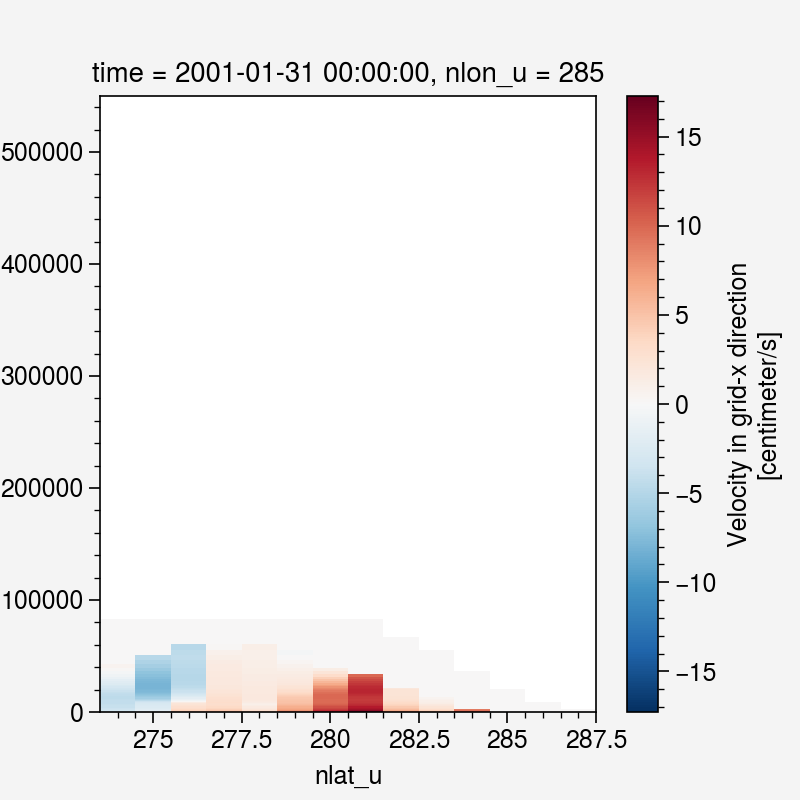

In [144]:
# uvel_cs_TL.isel(time=0, z_t=0).plot()
uvel_cs_TL = uvel_r_TL[:,:,nlat1_r2_g16:nlat2_r2_g16, nlon1_r2_g16]
uvel_cs_TL.isel(time=0).plot()
uvel_cs_TL.ULONG.values-360

In [49]:
print(kmu_r_TH.dims)
kmu_cs_TH = kmu_r_TH[nlat1_r2_t12:nlat2_r2_t12, nlon1_r2_t12]
print(kmu_cs_TH.values)
kmt_cs_TH = kmt_r_TH[nlat1_r2_t12:nlat2_r2_t12, nlon1_r2_t12]
print(kmu_cs_TH.values)

('nlat_u', 'nlon_u')
[ 0.  0.  0.  0.  0.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  4.  4.  4.  4.  5.  5.  5.  8. 10.  9.  9. 10. 12. 16. 20. 22. 21. 18.
 17. 16. 16. 16. 17. 16. 14. 13. 12.  9.  7.  7.  6.  5.  4.  4.  4.  4.
  4.  4.  4.  4.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  0.
  0.  0.  0.]
[ 0.  0.  0.  0.  0.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  4.  4.  4.  4.  5.  5.  5.  8. 10. 10.  9. 10. 12. 16. 20. 22. 24. 21.
 18. 17. 16. 16. 17. 18. 16. 14. 13. 12.  9.  7.  7.  6.  5.  4.  4.  4.
  4.  4.  4.  4.  4.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  0.  0.  0.]


In [39]:
ug_cs_TH = Ug_r_TH[:,nlat1_r2_t12:nlat2_r2_t12, nlon1_r2_t12]
ug_cs_TH.isel(time=0).values
qg_cs_TH.isel(time=0).values

array([            nan,             nan,             nan,             nan,
                   nan, -1.71316627e+10,  1.44810375e+09, -6.46327832e+09,
       -3.92968865e+09, -2.62701435e+09,  3.54639221e+09,  9.98965326e+09,
        1.15734653e+10,  1.73293462e+10,  1.77310608e+10,  1.34525855e+10,
        5.59578789e+09,  6.31947935e+09, -1.23665701e+10,  3.75982220e+09,
        2.61314899e+10,  4.53136853e+10,  1.49612896e+10, -5.33984879e+10,
       -1.28530644e+11, -1.94638057e+11, -1.35086771e+11, -5.31898696e+10,
        2.32813022e+10,  6.38377767e+10, -5.30867286e+10, -5.79874817e+10,
        6.93893845e+10,  1.41651990e+11,  1.84725737e+11,  1.72586138e+11,
        1.48600948e+11,  1.20871613e+11,  1.01420340e+11,  1.08996884e+11,
        1.11246040e+11,  4.71943043e+10,  9.72002434e+09,  3.90601181e+10,
       -3.86056455e+10, -4.69170839e+10,  1.41076749e+10,  4.08746866e+10,
        2.69336507e+10,  5.09769087e+09,  2.36093579e+09,  9.52875009e+09,
        8.74479128e+09,  

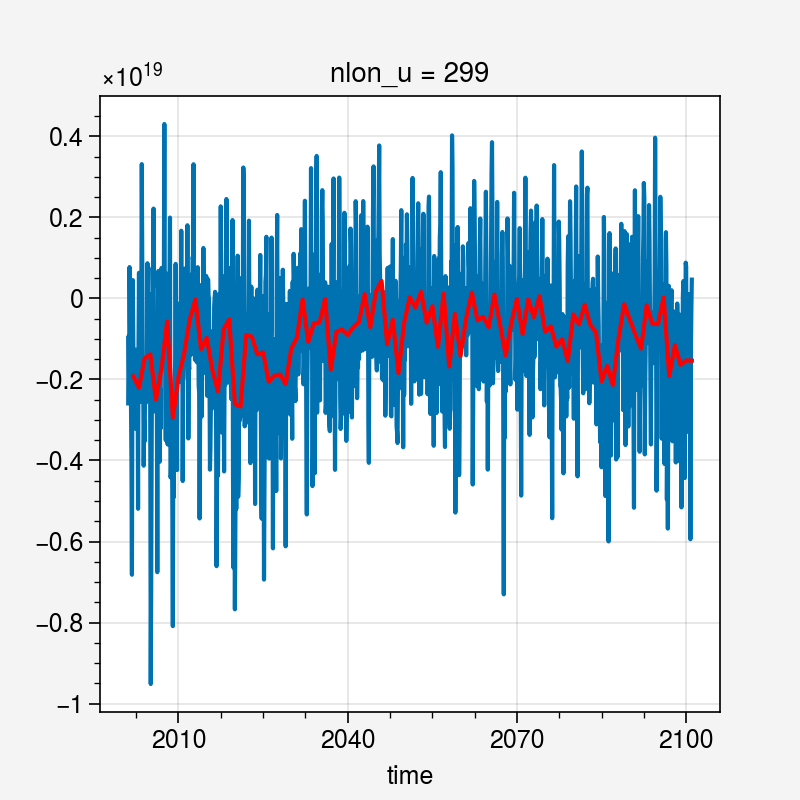

In [60]:
Tg_cs_TH.plot()
Tg_cs_TH.resample(time='A').mean().plot(color='r')

In [ ]:
qg_cs_TH = ug_cs_TH*dzu_cs_zsum_TH_np*dyu_cs_TH

('z_t', 'nlat_u') (62, 75)
(75,) (1200, 75)


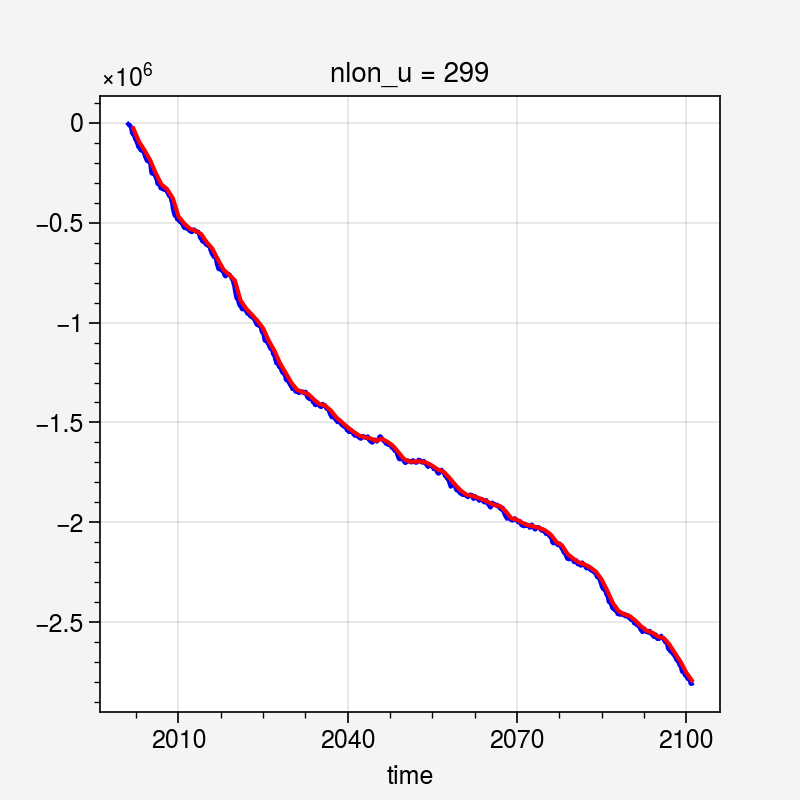

In [48]:




# dyu_cs_TH.dims
print(dzu_cs_TH.fillna(0).dims, dzu_cs_TH.fillna(0).shape)
dzu_cs_TH.fillna(0).values.sum(axis=1)
area_cs_TH_np = dyu_cs_TH.values*dzu_cs_TH.fillna(0).values
area_cs_zsum_TH_np =  area_cs_TH_np.sum(axis=0)
print(area_cs_zsum_TH_np.shape, ug_cs_TH.shape)
qg_cs_TH = ug_cs_TH*area_cs_zsum_TH_np
qg_cs_TH
Qg_cs_TH = qg_cs_TH.sum('nlat_u')
Qg_cs_TH = Qg_cs_TH.compute()

sec_in_month = Qg_cs_TH.time.dt.days_in_month.values*86400
Tg_cs_TH = -Qg_cs_TH*sec_in_month
ssh_ug_csbox_TH = Tg_cs_TH.cumsum('time')/tarea_r2msum_TH

ssh_ug_csbox_TH.plot(color='b')
ssh_ug_csbox_TH.resample(time='A').mean('time').plot(color='r')

In [32]:
print(Ug_r_TH.dims)
ug_cs_TH = Ug_r_TH[:,nlat1_r2_t12:nlat2_r2_t12, nlon1_r2_t12]
ug_cs_TH

qg_cs_TH = ug_cs_TH*dyu_cs_TH.values*dzu_cs_TH.fillna(0).values
# print('q_cs_TH.dims', q_cs_TH.dims)
# Q_cs_TH = q_cs_TH.sum(('nlat_u','z_t'))
# Q_cs_TH = Q_cs_TH.compute()
# Q_cs_TH

# sec_in_month = Q_cs_TH.time.dt.days_in_month.values*86400
# T_cs_TH = -Q_cs_TH*sec_in_month

('time', 'nlat_u', 'nlon_u')


ValueError: operands could not be broadcast together with shapes (1200, 75) (62, 75)

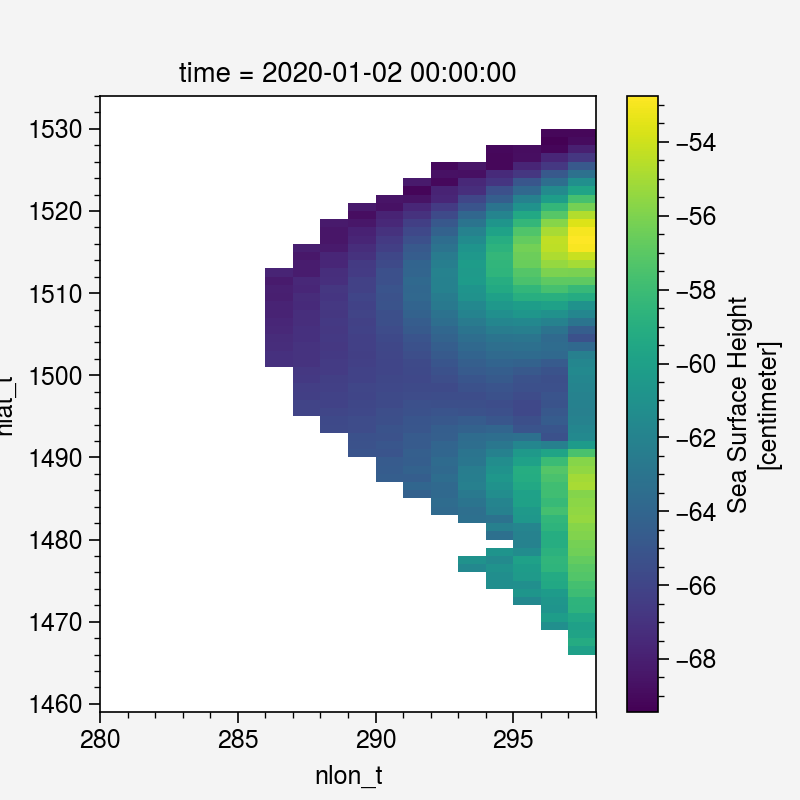

In [79]:
ssh_r_daily_TH = xds_ssh_daily_TH.SSH.isel(nlon_t=slice(nlon1_r_t12, nlon2_r_t12),
                                           nlat_t=slice(nlat1_r_t12, nlat2_r_t12))
# ssh_r_daily_TH
ssh_r2_daily_TH = ssh_r_daily_TH[:,nlat1_r2_t12:nlat2_r2_t12, 0:nlon1_r2_t12]
ssh_r2m_daily_TH = ssh_r2_daily_TH.where(kmt_r2_TH>0, np.nan)
ssh_r2m_daily_TH.isel(time=0).plot()

ssh_r2msum_daily_TH = (ssh_r2m_daily_TH*tarea_r2m_TH.values).sum(('nlon_t','nlat_t'))
# ssh_r2mav_TH = ssh_r2msum_TH/tarea_r2msum_TH
ssh_r2msum_daily_TH

# CESM-TNST HR Ens#1 has missing time: 2033-07, 2038-09, 2052-11
T_cs_203307_TH = ssh_r2msum_daily_TH.sel(time='2033-07-31').values - ssh_r2msum_daily_TH.sel(time='2033-07-01').values # cm^3
T_cs_203809_TH = ssh_r2msum_daily_TH.sel(time='2038-09-30').values - ssh_r2msum_daily_TH.sel(time='2038-09-01').values # cm^3
T_cs_205211_TH = ssh_r2msum_daily_TH.sel(time='2052-11-30').values - ssh_r2msum_daily_TH.sel(time='2052-11-01').values # cm^3

In [38]:
# need lat and lon (no masks over lands)
grid_t12, xds_t12 = pop_tools.to_xgcm_grid_dataset(ds_t12)
xds_t12
xds_r_t12 = xds_t12.isel(nlon_u=slice(nlon1_r_t12, nlon2_r_t12), nlat_u=slice(nlat1_r_t12, nlat2_r_t12))

grid_g16, xds_g16 = pop_tools.to_xgcm_grid_dataset(ds_g16)
xds_g16
xds_r_g16 = xds_g16.isel(nlon_u=slice(nlon1_r_g16, nlon2_r_g16), nlat_u=slice(nlat1_r_g16, nlat2_r_g16))

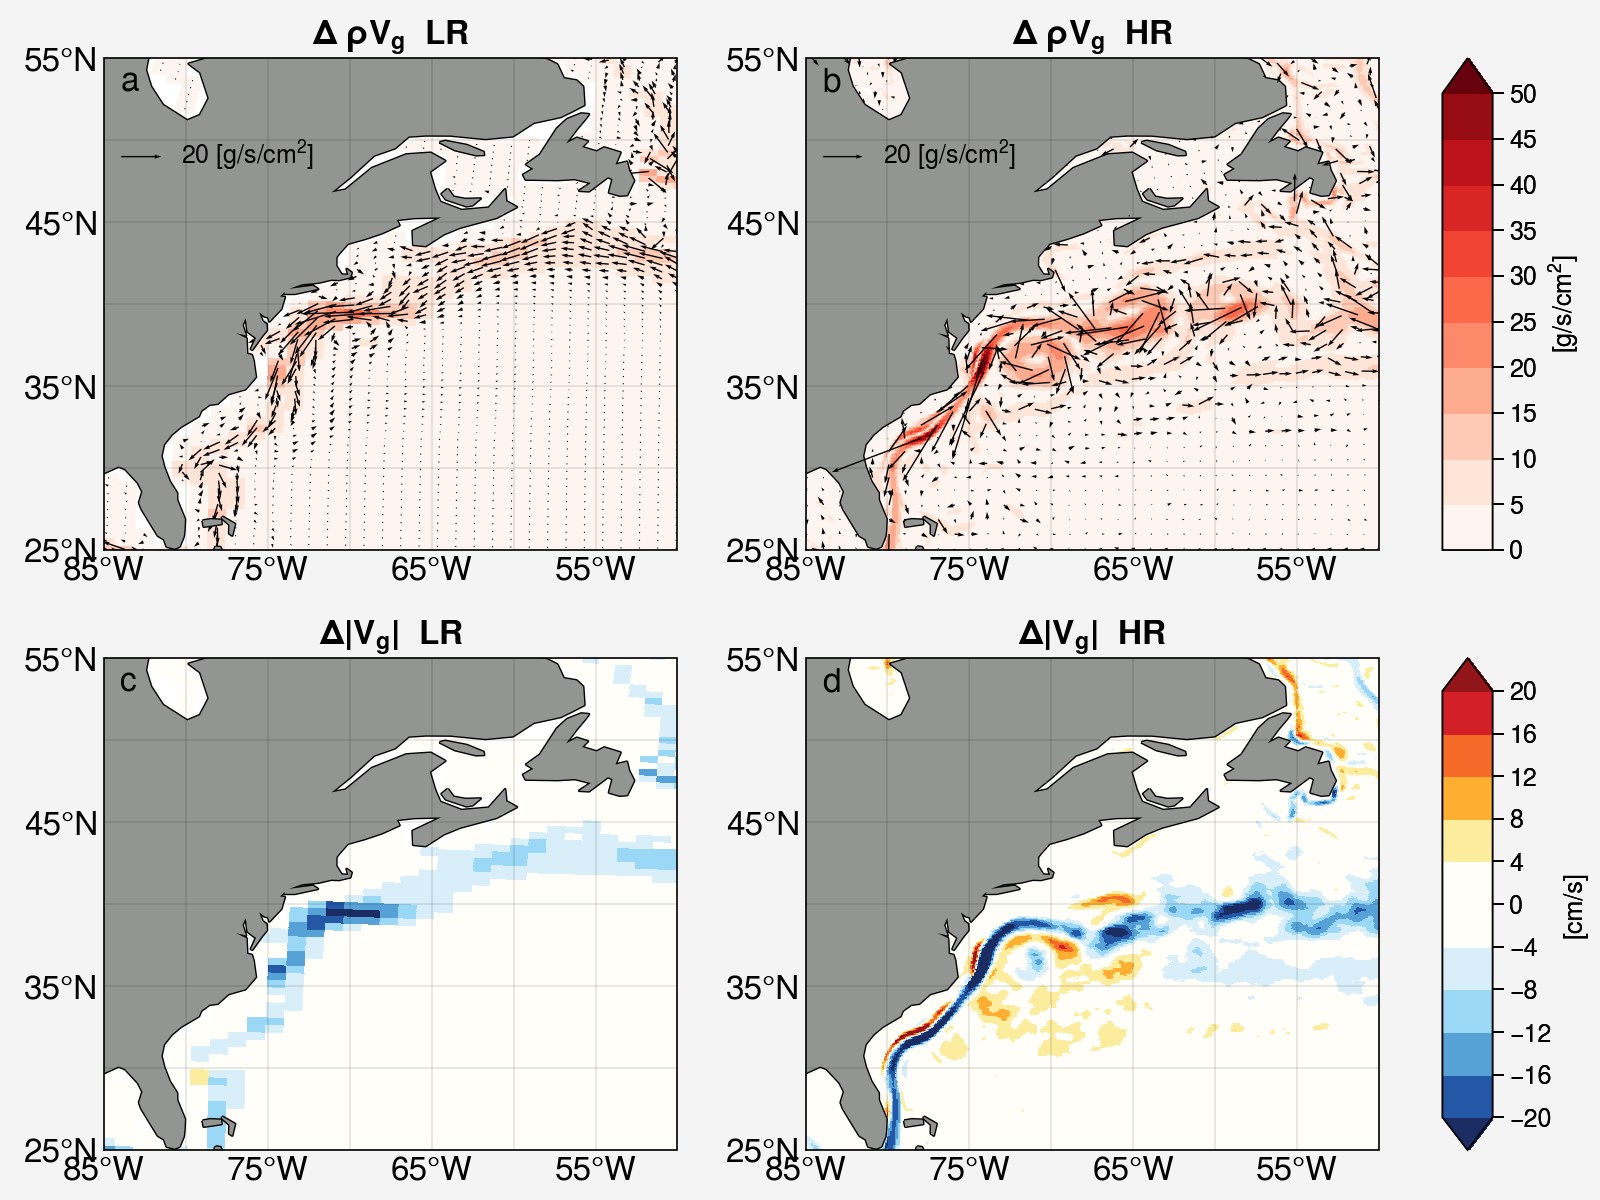

In [39]:
pc = cartopy.crs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

# Fig 1 Vg*PD
fig1, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='8in',height='6in')

spd_UgPD_z1_r_dt_TLmCL = xr.ufuncs.sqrt(UgPD_z1_r_dt_TLmCL**2+VgPD_z1_r_dt_TLmCL**2)
m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, spd_UgPD_z1_r_dt_TLmCL, 
                        levels=np.arange(0, 50.01, 5), transform=pc, cmap="Reds", extend='max')
q00 = axs[0,0].quiver(xds_r_g16.ULONG, xds_r_g16.ULAT, UgPD_z1_r_dt_TLmCL, VgPD_z1_r_dt_TLmCL,
                      transform=pc, scale=100, scale_units='inches')
axs[0,0].quiverkey(q00, X=0.1, Y=0.8, U=20, label=r'20 [g/s/$cm^2$]', labelpos='E')
# axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title(r'$\Delta$ $\rho V_{g}$  LR', fontsize=12, fontweight='bold')
axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')

spd_UgPD_z1_r_dt_THmCH = xr.ufuncs.sqrt(UgPD_z1_r_dt_THmCH**2+VgPD_z1_r_dt_THmCH**2)
m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, spd_UgPD_z1_r_dt_THmCH, 
                        levels=np.arange(0, 50.01, 5), transform=pc, cmap="Reds", extend='max')
q01 = axs[0,1].quiver(xds_r_t12.ULONG[::10,::10], xds_r_t12.ULAT[::10,::10], 
                UgPD_z1_r_dt_THmCH[::10,::10], VgPD_z1_r_dt_THmCH[::10, ::10], transform=pc, scale=100, scale_units='inches')
q01.set_zorder(2)
axs[0,1].quiverkey(q01, X=0.1, Y=0.8, U=20, label=r'20 [g/s/$cm^2$]', labelpos='E')
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title(r'$\Delta$ $\rho V_{g}$  HR', fontsize=12, fontweight='bold')
axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=12)
# add colorbar
cb = axs[0,1].colorbar(m01,loc='r', label=r'[g/s/$cm^2$]',width='2em')

cut=-0.1
m10=axs[1,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, spd_Vg_r_dt_TLmCL, 
                        levels=np.arange(-20,20+0.1,4), transform=pc, cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title(r'$\Delta |V_{g}|$  LR', fontsize=12, fontweight='bold')
axs[1,0].text(-84, 53, 'c', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')


m11=axs[1,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, spd_Vg_r_dt_THmCH, 
                        levels=np.arange(-20,20+0.1,4), transform=pc, cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title(r'$\Delta |V_{g}|$  HR', fontsize=12, fontweight='bold')
axs[1,1].text(-84, 53, 'd', transform=pc, fontsize=12)
# add colorbar
cb = axs[1,1].colorbar(m11,loc='r', label='[cm/s]',width='2em')

# fig1.savefig(pic1,bbox_inches='tight')

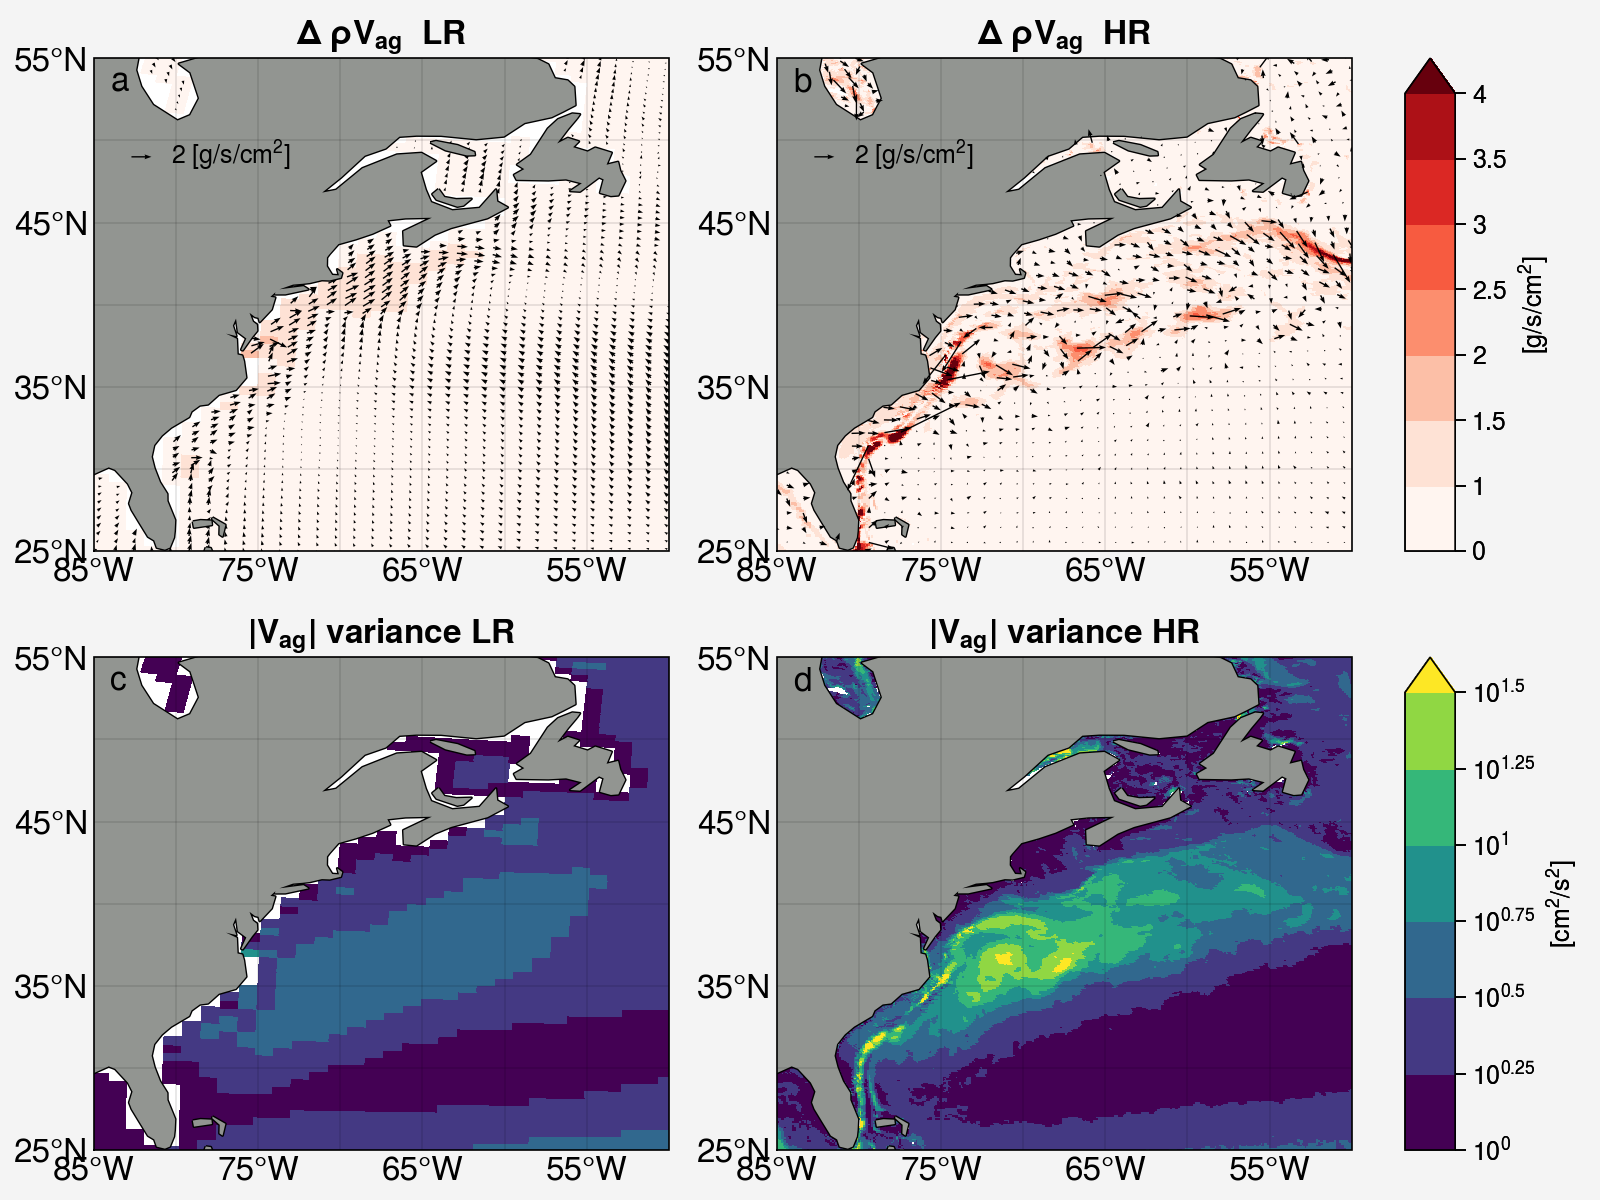

In [40]:
# Fig 2 Vag*PD
fig2, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='8in',height='6in')
# np.arange(0, 4.01, 0.5)
spd_UagPD_z1_r_dt_TLmCL = xr.ufuncs.sqrt(UagPD_z1_r_dt_TLmCL**2+VagPD_z1_r_dt_TLmCL**2)
m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, spd_UagPD_z1_r_dt_TLmCL, 
                        levels=[0,1,1.5,2,2.5,3,3.5,4], transform=pc, cmap="Reds", extend='max')
q00 = axs[0,0].quiver(xds_r_g16.ULONG, xds_r_g16.ULAT, UagPD_z1_r_dt_TLmCL, VagPD_z1_r_dt_TLmCL, 
                      transform=pc, scale=20, scale_units='inches',headwidth=3.5)
axs[0,0].quiverkey(q00, X=0.1, Y=0.8, U=2, label=r'2 [g/s/$cm^2$]', labelpos='E')
# axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title(r'$\Delta$ $\rho V_{ag}$  LR', fontsize=12, fontweight='bold')
axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')


spd_UagPD_z1_r_dt_THmCH = xr.ufuncs.sqrt(UagPD_z1_r_dt_THmCH**2+VagPD_z1_r_dt_THmCH**2)
# spd_UagPD_z1_r_dt_TH = xr.ufuncs.sqrt(UagPD_z1_r_dt_TH**2+VagPD_z1_r_dt_TH**2)
m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, spd_UagPD_z1_r_dt_THmCH, 
                        levels=[0,1,1.5,2,2.5,3,3.5,4], transform=pc, cmap="Reds", extend='max')
# --- too many quivers, hard to read color ---
# q11 = axs[1,1].quiver(xds_r_t12.ULONG[::5,::5], xds_r_t12.ULAT[::5,::5], 
#                 UagPD_z1_r_dt_TH[::5,::5].where(spd_UagPD_z1_r_dt_TH>0.02), 
#                 VagPD_z1_r_dt_TH[::5,::5].where(spd_UagPD_z1_r_dt_TH>0.02), transform=pc, scale=0.2, scale_units='inches')
# --------------------------------------------
# --- too many quivers, hard to read color ---
# q11 = axs[1,1].quiver(xds_r_t12.ULONG, xds_r_t12.ULAT, 
#                 UagPD_z1_r_dt_TH.where(spd_UagPD_z1_r_dt_TH>0.02), 
#                 VagPD_z1_r_dt_TH.where(spd_UagPD_z1_r_dt_TH>0.02), transform=pc, scale=0.2, scale_units='inches')
# --------------------------------------------
q01 = axs[0,1].quiver(xds_r_t12.ULONG[5::10,5::10], xds_r_t12.ULAT[5::10,5::10], 
                      UagPD_z1_r_dt_THmCH[5::10,5::10], VagPD_z1_r_dt_THmCH[5::10,5::10], 
                      transform=pc, scale=20, scale_units='inches',headwidth=3.5)
q01.set_zorder(2)
axs[0,1].quiverkey(q01, X=0.1, Y=0.8, U=2, label=r'2 [g/s/$cm^2$]', labelpos='E')
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title(r'$\Delta$ $\rho V_{ag}$  HR', fontsize=12, fontweight='bold')
axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=12)
# add colorbar
cb = axs[0,1].colorbar(m01,loc='r', label=r'[g/s/$cm^2$]',width='2em')

m10=axs[1,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, np.log10(spd_Vag_r_t1var_TL), 
                        levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title(r'$|V_{ag}|$ variance LR', fontsize=12, fontweight='bold')
axs[1,0].text(-84, 53, 'c', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')

m11=axs[1,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, np.log10(spd_Vag_r_t1var_TH), 
                        levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title(r'$|V_{ag}|$ variance HR', fontsize=12, fontweight='bold')
axs[1,1].text(-84, 53, 'd', transform=pc, fontsize=12)
# add colorbar
cb = axs[1,1].colorbar(m11,loc='r', label=r'[$cm^2$/$s^2$]',width='2em', ticks=np.arange(0,1.51,0.25), 
                       ticklabels=[r'$10^0$',r'$10^{0.25}$',r'$10^{0.5}$',r'$10^{0.75}$',r'$10^{1}$',r'$10^{1.25}$',r'$10^{1.5}$'])
# fig2.savefig(pic2,bbox_inches='tight')

/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/dask/array/core.py:1527: FutureWarning: The `numpy.column_stack` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/dask/array/core.py:1527: FutureWarning: The `numpy.column_stack` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


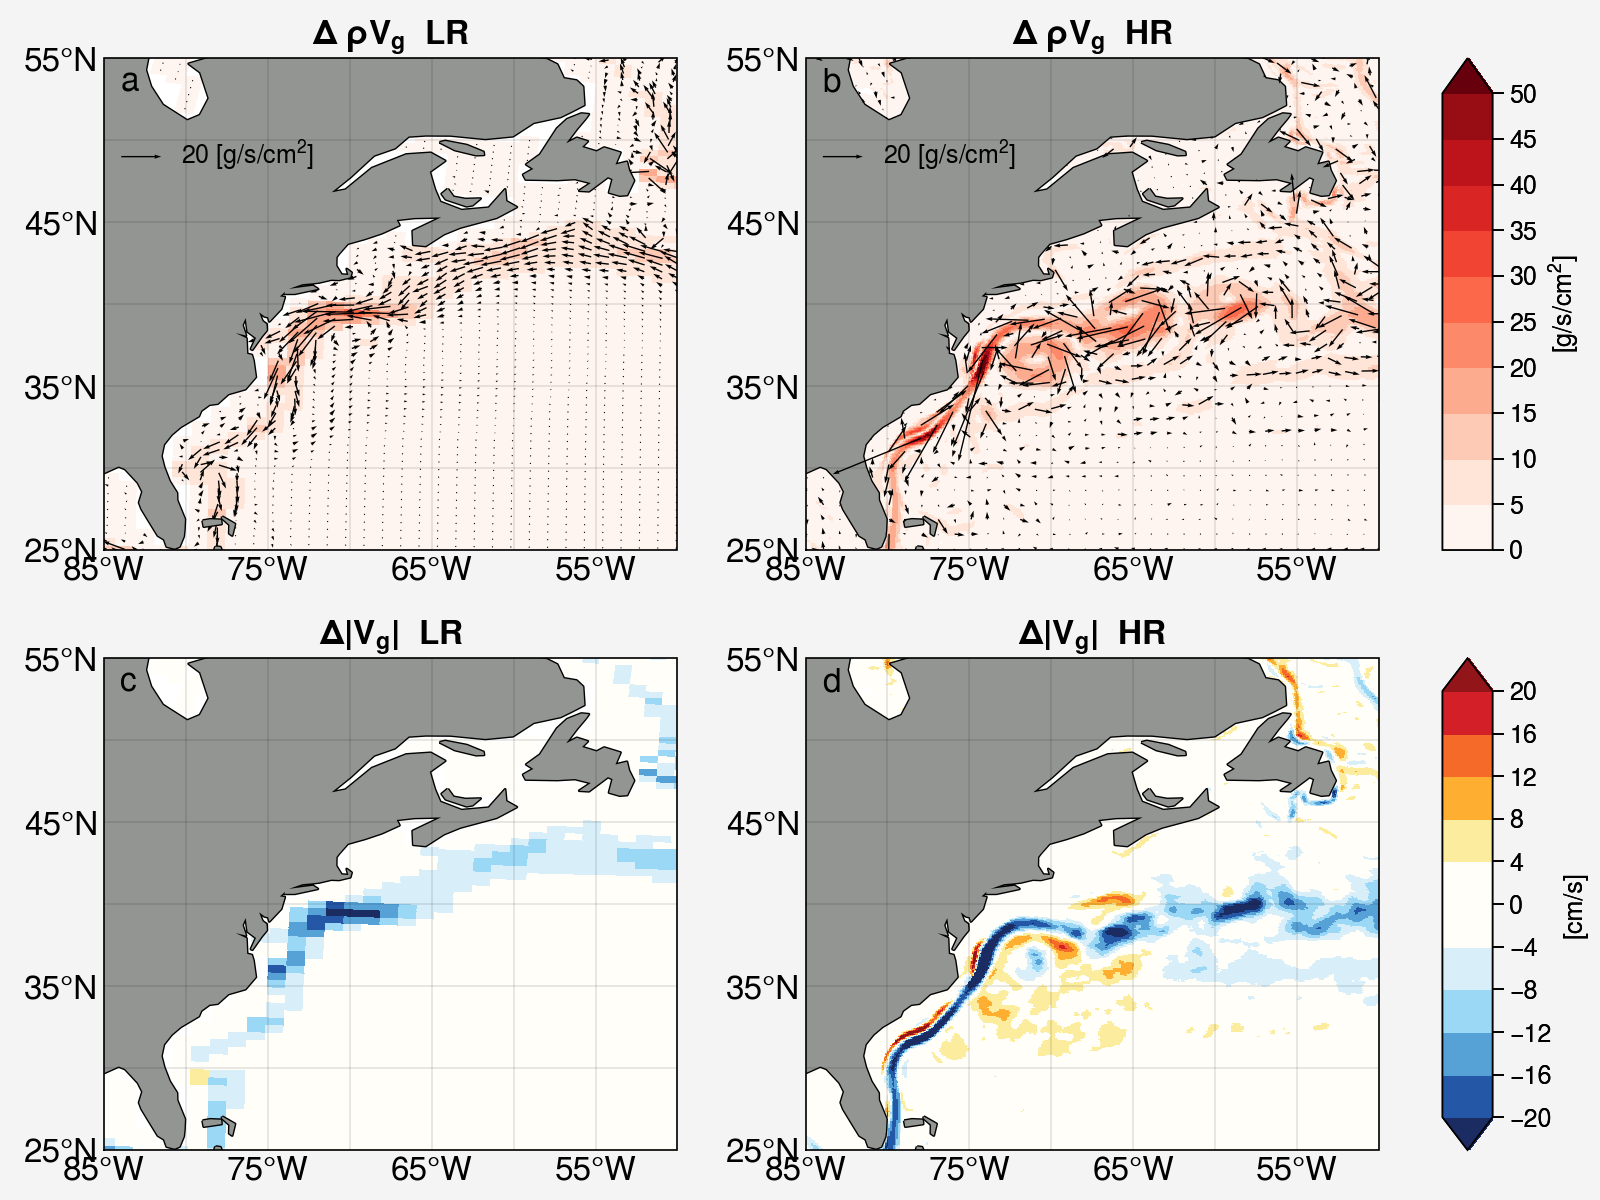

In [58]:
pc = cartopy.crs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

# Fig 1 Vg*PD
fig1, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='8in',height='6in')

spd_UgPD_z1_r_dt_TLmCL = xr.ufuncs.sqrt(UgPD_z1_r_dt_TLmCL**2+VgPD_z1_r_dt_TLmCL**2)
m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, spd_UgPD_z1_r_dt_TLmCL, 
                        levels=np.arange(0, 50.01, 5), transform=pc, cmap="Reds", extend='max')
q00 = axs[0,0].quiver(xds_r_g16.ULONG, xds_r_g16.ULAT, UgPDr_z1_r_dt_TLmCL, VgPDr_z1_r_dt_TLmCL,
                      transform=pc, scale=100, scale_units='inches')
axs[0,0].quiverkey(q00, X=0.1, Y=0.8, U=20, label=r'20 [g/s/$cm^2$]', labelpos='E')
# axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title(r'$\Delta$ $\rho V_{g}$  LR', fontsize=12, fontweight='bold')
axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')

spd_UgPD_z1_r_dt_THmCH = xr.ufuncs.sqrt(UgPD_z1_r_dt_THmCH**2+VgPD_z1_r_dt_THmCH**2)
m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, spd_UgPD_z1_r_dt_THmCH, 
                        levels=np.arange(0, 50.01, 5), transform=pc, cmap="Reds", extend='max')
q01 = axs[0,1].quiver(xds_r_t12.ULONG[::10,::10], xds_r_t12.ULAT[::10,::10], 
                UgPDr_z1_r_dt_THmCH[::10,::10], VgPDr_z1_r_dt_THmCH[::10, ::10], transform=pc, scale=100, scale_units='inches')
q01.set_zorder(2)
axs[0,1].quiverkey(q01, X=0.1, Y=0.8, U=20, label=r'20 [g/s/$cm^2$]', labelpos='E')
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title(r'$\Delta$ $\rho V_{g}$  HR', fontsize=12, fontweight='bold')
axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=12)
# add colorbar
cb = axs[0,1].colorbar(m01,loc='r', label=r'[g/s/$cm^2$]',width='2em')

cut=-0.1
m10=axs[1,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, spd_Vg_r_dt_TLmCL, 
                        levels=np.arange(-20,20+0.1,4), transform=pc, cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title(r'$\Delta |V_{g}|$  LR', fontsize=12, fontweight='bold')
axs[1,0].text(-84, 53, 'c', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')


m11=axs[1,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, spd_Vg_r_dt_THmCH, 
                        levels=np.arange(-20,20+0.1,4), transform=pc, cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title(r'$\Delta |V_{g}|$  HR', fontsize=12, fontweight='bold')
axs[1,1].text(-84, 53, 'd', transform=pc, fontsize=12)
# add colorbar
cb = axs[1,1].colorbar(m11,loc='r', label='[cm/s]',width='2em')

# fig1.savefig(pic1,bbox_inches='tight')